# ECE 157A/272A Homework 3

You are a new ML engineer on your first day at the semiconductor company **WIWI**.  
Your mentor, **Kiwi**, approaches you and says:  
> “The testing team just sent us wafer map test data from the new product line.”

Kiwi’s team usually starts by labeling the wafer maps according to their **failure patterns** whenever new test data arrives.  
That’s because wafer maps are directly related to **yield**, and by analyzing the patterns, engineers can infer which **process step** or **test stage** may have caused issues — leading to potential solutions.

Kiwi continues,  
> “I’d like you to build a Machine Learning model that can quickly classify the wafer map failure patterns we used to label manually.”

Then adds,  
> “You’re the only ML expert on our team. So you’ll not only need to build the model and report the results, but also **explain** to us — including me — *how* the model makes its classifications, *how accurate* it is, and *what principles* it’s based on.  
> I’ll give you **two weeks**. We have high expectations!”

You’d love to use a **Deep Neural Network**, but you decide it’s better to start simple to make your explanations and reasoning clear to the team.  
Over the next two weeks, you make the following plan:

1. Instead of using the new wafer map data right away, start with a well-known, validated dataset — **WM-811K**.  
2. Explore the data: *What types of failure patterns are we trying to identify?*  
3. Determine what **features** are needed to classify those patterns.  
4. Choose an appropriate **model** for classification.  
5. Based on the results, figure out how to **explain and justify** your model’s reasoning in a way that’s easy for everyone to understand.


### STEP 0. Setup LLM

(Stepping out of the story for a moment,) this assignment is **similar yet different** from the previous ones.  
In earlier assignments, your goal was to craft a **single precise prompt**.  
This time, however, your goal is to **leverage an LLM to complete a long piece of code**.  
Still, one thing remains the same — you must understand **what your code does** after generating it.

What the TAs want to see this time is **how you communicate with the LLM**.  
Therefore, instead of directly asking questions on platforms like **ChatGPT**, **Claude**, or **Gemini**,  
you must ask all your questions **through API calls**.

After completing the provided `.ipynb` file, you will **upload the file** for submission.  
The TAs will grade your work based on two main criteria:

1. **Code completion:**  
   - Did you correctly complete the code?  
   - (There is no single “perfect” answer — as long as you can justify your code and its behavior to the TAs,  
     or, in the story, to **Kiwi and the team**, that’s acceptable.)
   - Also, you will submit the test data prediction to Gradescope.
2. **Your questions to the LLM:**  
   - As Kiwi requested, you need to prepare **“explanatory materials”** to help Kiwi’s team understand the work you’ve done.  
   - You don’t actually need to submit this material, but imagine you’re creating it — and **discuss with the LLM** what key explanation points should be included.
   - Next, there are some **reflective questions** worth thinking about as you work through this assignment.
     These are slightly different from simple “I don’t understand this term” questions.
     They are the kind of questions that, when someone else asks them, feel *obvious and insightful* — but when you try to come up with them yourself, they require deeper thought.
     Whenever such a question comes to mind, **call the LLM** and ask it directly.  
     If you include this kind of thoughtful questioning in your process, you’ll be rewarded with **generous bonus points**.


A helper function for making **LLM API calls** is included below.  
Instead of typing prompts directly into an LLM website, **use this function to ask as many questions as you’d like!**  
You may add cells anywhere in the notebook to call it.  

However, for your own **cost management** and to make grading easier,  
please **avoid setting the response length too long** for a single call.


In [300]:
import openai
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get API key from environment variable
openai.api_key = os.getenv("OPENAI_API_KEY")

def call_llm(prompt: str) -> None:
    response = openai.chat.completions.create(
        model="gpt-4o-mini",  # You can replace with other models, but be aware of their capabilities and costs
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt},
        ]
    )
    print(response.choices[0].message.content)
    return

call_llm(prompt="""
         return simple python code to add two numbers.
         """)

Here's a simple Python code snippet that adds two numbers:

```python
# Function to add two numbers
def add_two_numbers(num1, num2):
    return num1 + num2

# Example usage
a = 5
b = 3
result = add_two_numbers(a, b)
print("The sum of {} and {} is {}".format(a, b, result))
```

You can replace `a` and `b` with any two numbers you want to add together.


### STEP 1. About WM-811K

**WM-811K** is a real-world wafer map dataset collected from actual semiconductor **fab/foundry** processes.  
It contains **six columns**:  
`dieSize`, `failureType`, `lotName`, `trainTestLabel`, `waferIndex`, and `waferMap`.

In semiconductor manufacturing, chips (called **dies**) are not fabricated one by one.  
Instead, multiple identical dies are produced simultaneously on a single **circular silicon slice**, called a **wafer**.  
After the fabrication process, the wafer is diced into individual chips.

The most critical metric for semiconductor companies is **Yield**.  
Ideally, there would be no defective dies during fabrication or testing — but in reality, defects always occur.  
Therefore, companies dedicate substantial time and resources to **analyzing and resolving the causes** of these defective dies.

The **Yield per wafer** is defined as the number of **passing dies** (non-defective) divided by the **total number of dies** on that wafer.  
A **wafer map** is a visual representation of this — showing which dies **failed** and which **passed**.

Sometimes, wafer maps exhibit **distinct failure patterns**.  
When certain patterns appear frequently, engineers can infer which specific **process step** or **test stage** might be responsible.  
Fixing the root cause improves yield, which is why **analyzing wafer map failure patterns** is so important.

For this analysis, **accurate classification** of failure patterns is essential.  
Fortunately, the types of patterns needed by Kiwi’s team match the labels provided in the WM-811K dataset:

- **Center**  
- **Edge-Loc**  
- **Scratch**  
- **Donut**  
- **Near-full**


### STEP 2. Inspect dataset

In [301]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation
# This code prefers skimage for resize but you can also import and use cv2
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import binary_dilation, square

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

In [302]:
call_llm(prompt="""
I need to implement a Python function that saves a wafer map (numpy array) as an image file.

Function signature:
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None

Requirements:
1. Create the directory if it doesn't exist
2. Save the wafer map as an image using matplotlib
3. Use vmin and vmax for color scaling
4. Save as 'name.png' in the specified directory
5. Close the plot to avoid memory issues

Please provide a clean implementation using matplotlib.pyplot.
""")

Certainly! Below is an implementation of the `output_image` function using the specified requirements. It uses `matplotlib.pyplot` to save the wafer map as an image, creates the directory if it does not exist, and applies the specified color scaling.

```python
import numpy as np
import matplotlib.pyplot as plt
import os

def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:
    # Create the directory if it doesn't exist
    os.makedirs(dir, exist_ok=True)
    
    # Create the plot
    plt.figure(figsize=(8, 6))  # You can adjust the figure size as needed
    plt.imshow(wafer_map, cmap='viridis', vmin=vmin, vmax=vmax)  # You can choose any colormap you like
    plt.colorbar()  # Optional: adds a colorbar to the side
    
    # Set the title and labels if desired
    plt.title('Wafer Map')  # You can customize the title
    plt.xlabel('X-axis Label')  # Customize the labels
    plt.ylabel('Y-axis Label')
    
    # Save the figure
    plt.savef

In [303]:
# TODO: Implement a function that takes a wafer map and outputs it to a directory with the given name
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:
    # Create directory if it doesn't exist
    os.makedirs(dir, exist_ok=True)
    
    # Create figure and plot the wafer map
    plt.figure(figsize=(6, 6))
    plt.imshow(wafer_map, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.axis('off')
    
    # Save the image
    filepath = os.path.join(dir, f'{name}.png')
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    return


# TODO: Implement a function that outputs all wafer maps to corresponding failure type directories
def output_all_wafer_maps(df: pd.DataFrame) -> None:
    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        # Get the failure type and wafer index
        failure_type = row['failureType']
        wafer_index = row['waferIndex']
        wafer_map = row['waferMap']
        
        # Create directory path based on failure type
        dir_path = f'wafer_images/{failure_type}'
        
        # Save the wafer map image
        output_image(wafer_map, str(int(wafer_index)), dir_path)
    
    return

In [304]:
call_llm(prompt="""
I need to implement a function that iterates through a pandas DataFrame and saves all wafer maps to directories organized by their failure type.

Function signature:
def output_all_wafer_maps(df: pd.DataFrame) -> None

The DataFrame has columns:
- 'waferMap': numpy array containing the wafer map data
- 'failureType': string indicating the failure type (e.g., 'Center', 'Edge-Loc', 'Scratch', 'Donut', 'Near-full')
- 'waferIndex': unique identifier for each wafer

Requirements:
1. For each row in the dataframe, save the wafer map as an image
2. Organize images into subdirectories based on their failure type
3. Use the waferIndex as the filename
4. Use the output_image() function that's already implemented

Please provide the implementation.
""")

To implement the function `output_all_wafer_maps`, we need to iterate through each row of the provided DataFrame, save the wafer map images to directories organized by their respective failure types, and name the image files using the `waferIndex`. Let's break down the steps needed to do this:

1. **Import necessary libraries**: We'll need `os` to handle directory creation, and `pandas` for DataFrame manipulation.
2. **Iterate through each row of the DataFrame**: We can use the `iterrows()` method.
3. **Create directories if they don't already exist**: We can use `os.makedirs()` to create a directory for each failure type.
4. **Save each wafer map**: We'll use the provided `output_image()` function to save each map.

Here's how the function could be implemented:

```python
import os
import pandas as pd

def output_all_wafer_maps(df: pd.DataFrame) -> None:
    for index, row in df.iterrows():
        # Extract information from the row
        wafer_map = row['waferMap']
        failure_

In [305]:
call_llm(prompt="""
I need to implement a function that creates a single plot showing one wafer map example from each failure type in a grid layout.

Function signature:
def visualize_failure_types(df: pd.DataFrame, figsize=(16,9), index_off: int = 0) -> None

The DataFrame has:
- 'waferMap': numpy arrays of wafer maps
- 'failureType': failure type labels (Center, Edge-Loc, Scratch, Donut, Near-full)

Requirements:
1. Create a subplot grid to show one wafer map from each unique failure type
2. Use the figsize parameter for the figure size
3. Use index_off parameter to select which example to show from each failure type (allows showing different examples)
4. Display each wafer map with its failure type as the title
5. Use plt.show() at the end
6. Arrange subplots in a single row or appropriate grid

Please provide the implementation using matplotlib subplots.
""")

To achieve the task you specified, we'll implement the `visualize_failure_types` function using `pandas` for handling the DataFrame, and `matplotlib` for visualizing the wafer maps. Below is an implementation that meets all the requirements you've outlined.

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_failure_types(df: pd.DataFrame, figsize=(16, 9), index_off: int = 0) -> None:
    # Get the unique failure types
    failure_types = df['failureType'].unique()
    
    # Create a figure and a set of subplots
    n_failure_types = len(failure_types)
    fig, axes = plt.subplots(1, n_failure_types, figsize=figsize)
    
    # Iterate through each failure type and corresponding subplot
    for ax, failure_type in zip(axes, failure_types):
        # Filter the DataFrame for the current failure type
        failure_df = df[df['failureType'] == failure_type]
        
        # Check if we have enough examples, and select the index_off example

In [306]:
# TODO: Implement a function that generate a single plot showing one wafer map example from each failure type
def visualize_failure_types(df: pd.DataFrame, figsize=(16,9), index_off: int = 0) -> None:
    # Get unique failure types
    failure_types = df['failureType'].unique()
    num_types = len(failure_types)
    
    # Create subplots - one for each failure type
    fig, axes = plt.subplots(1, num_types, figsize=figsize)
    
    # If only one failure type, axes won't be an array
    if num_types == 1:
        axes = [axes]
    
    # Plot one example from each failure type
    for idx, failure_type in enumerate(failure_types):
        # Get all wafer maps of this failure type
        subset = df[df['failureType'] == failure_type]
        
        # Select the wafer map at index_off position
        if index_off < len(subset):
            wafer_map = subset.iloc[index_off]['waferMap']
        else:
            wafer_map = subset.iloc[0]['waferMap']  # Fallback to first if index_off is too large
        
        # Plot the wafer map
        axes[idx].imshow(wafer_map, cmap='viridis', vmin=0, vmax=2)
        axes[idx].set_title(failure_type, fontsize=14)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    return

In [307]:
call_llm(prompt="""
I need to load a training dataset from a .npy file and convert it to a pandas DataFrame.

The file is located at 'data/wafermap_train.npy' and contains wafer map data from the WM-811K dataset.

According to the dataset description, it should have these columns:
- dieSize
- failureType  
- lotName
- trainTestLabel
- waferIndex
- waferMap

Requirements:
1. Load the .npy file using numpy
2. Convert it to a pandas DataFrame
3. The .npy file likely contains a structured array or object array

Please provide the implementation to load and convert this data.
""")

Certainly! You can load the `.npy` file and convert it into a pandas DataFrame by following these steps using NumPy to load the data and pandas to create the DataFrame. Here's how you can do it:

```python
import numpy as np
import pandas as pd

# Step 1: Load the .npy file
file_path = 'data/wafermap_train.npy'
data = np.load(file_path, allow_pickle=True)

# Step 2: Convert the loaded data to a pandas DataFrame
# Assuming data is a structured array or an object array
df = pd.DataFrame(data.tolist())

# Step 3: Ensure the DataFrame has the correct column names
# Alternatively, you can rename them if needed
df.columns = ['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap']

# Display the first few rows of the DataFrame to verify
print(df.head())
```
### Explanation:
1. **Loading the .npy file**: The `np.load()` function is used to load the `.npy` file. The `allow_pickle=True` argument is necessary when dealing with object arrays.
  
2. **Converting to DataFram

In [308]:
# TODO: load training dataset as pandas dataframe
# Load the .npy file
data_train = np.load('data/wafermap_train.npy', allow_pickle=True)

# Convert to pandas DataFrame
df_train = pd.DataFrame(data_train)

In [309]:
call_llm(prompt="""
I have loaded a pandas DataFrame from the WM-811K wafer map dataset and need to inspect its structure and contents.

The DataFrame should contain the following columns:
- dieSize: Size of each die on the wafer
- failureType: The failure pattern type (Center, Edge-Loc, Scratch, Donut, Near-full)
- lotName: Lot identifier
- trainTestLabel: Label indicating train/test split
- waferIndex: Unique identifier for each wafer
- waferMap: Numpy array containing the actual wafer map data

What pandas methods should I use to:
1. View the first few rows of the dataset
2. Get information about the DataFrame structure (columns, data types, memory usage)
3. Check the shape (number of rows and columns)
4. Verify the column names match what we expect

Please suggest the appropriate pandas inspection methods.
""")

To inspect the structure and contents of your pandas DataFrame, you can use the following methods:

1. **View the first few rows of the dataset**: 
   - Use the `head()` method to view the first few rows. By default, it shows the first 5 rows, but you can specify a different number if needed.
   ```python
   df.head()  # This shows the first 5 rows
   ```

2. **Get information about the DataFrame structure (columns, data types, memory usage)**: 
   - Use the `info()` method to get a concise summary of the DataFrame, including the index dtype and column dtypes, non-null values, and memory usage.
   ```python
   df.info()
   ```

3. **Check the shape (number of rows and columns)**: 
   - Use the `shape` attribute to check the number of rows and columns in the DataFrame.
   ```python
   df.shape  # This returns a tuple (number of rows, number of columns)
   ```

4. **Verify the column names match what we expect**: 
   - Use the `columns` attribute to get the list of column names and compa

In [310]:
# TODO: use pandas to inspect the dataset information
# Display basic information about the DataFrame
print("DataFrame Shape:", df_train.shape)
print("\nColumn Names:")
print(df_train.columns.tolist())
print("\nDataFrame Info:")
df_train.info()
print("\nFirst few rows:")
df_train.head()

DataFrame Shape: (2746, 6)

Column Names:
['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap']

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dieSize         2746 non-null   float64
 1   failureType     2746 non-null   object 
 2   lotName         2746 non-null   object 
 3   trainTestLabel  2746 non-null   object 
 4   waferIndex      2746 non-null   float64
 5   waferMap        2746 non-null   object 
dtypes: float64(2), object(4)
memory usage: 128.8+ KB

First few rows:


,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,3203.0,Center,lot10006,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1250.0,Center,lot10067,Training,9.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2393.0,Center,lot10731,Training,9.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,2393.0,Center,lot10742,Training,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2393.0,Center,lot10813,Training,12.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [311]:
call_llm(prompt="""
I need to inspect the 'dieSize' column in my wafer map DataFrame to understand its distribution.

The dieSize represents the size of each die on the wafer. I want to:
1. See the unique values and their frequency
2. Understand the distribution of die sizes in the dataset
3. Get basic statistics (min, max, mean, median)

What pandas methods should I use to explore this numerical column?
Please suggest appropriate methods for analyzing the dieSize distribution.
""")

To analyze the `dieSize` column in your wafer map DataFrame using pandas, you can use the following methods and functions to get the insights you need.

1. **Unique Values and Their Frequency:**
   You can use the `value_counts()` method to see the unique values in the `dieSize` column and their corresponding frequencies.

   ```python
   unique_values = df['dieSize'].value_counts()
   print(unique_values)
   ```

2. **Understanding the Distribution:**
   To visualize the distribution of die sizes, you can use plotting libraries like Matplotlib or Seaborn, in conjunction with pandas.

   - A histogram can be helpful to understand the distribution visually:
   
   ```python
   import matplotlib.pyplot as plt

   df['dieSize'].hist(bins=30)  # You can adjust the number of bins
   plt.xlabel('Die Size')
   plt.ylabel('Frequency')
   plt.title('Distribution of Die Sizes')
   plt.show()
   ```

   - Alternatively, you can use a kernel density estimate if you want a smoother representation:


In [312]:
# TODO: inspect the dieSize
print("Die Size Statistics:")
print(df_train['dieSize'].describe())
print("\nDie Size Value Counts:")
print(df_train['dieSize'].value_counts().sort_index())
print("\nNumber of unique die sizes:", df_train['dieSize'].nunique())

Die Size Statistics:
count     2746.000000
mean      2379.422433
std       2127.115602
min       1032.000000
25%       1334.000000
50%       1683.000000
75%       2393.000000
max      15550.000000
Name: dieSize, dtype: float64

Die Size Value Counts:
dieSize
1032.0      2
1044.0      1
1060.0      4
1073.0     20
1075.0      1
           ..
12662.0     2
13301.0    38
14116.0     5
15545.0     6
15550.0     1
Name: count, Length: 255, dtype: int64

Number of unique die sizes: 255


In [313]:
call_llm(prompt="""
I need to inspect the 'failureType' column in my wafer map DataFrame and visualize its distribution using a histogram.

The failure types are categorical labels (Center, Edge-Loc, Scratch, Donut, Near-full) that indicate different wafer map failure patterns.

I want to:
1. See the unique failure types and their counts
2. Calculate the percentage distribution of each failure type
3. Create a histogram/bar chart to visualize the distribution

What pandas and matplotlib methods should I use to:
- Get value counts for the categorical failureType column
- Create a histogram or bar chart showing the distribution
- Display counts and/or percentages for each failure type

Please suggest the appropriate methods for analyzing and visualizing categorical data distribution.
""")

To inspect the 'failureType' column in your wafer map DataFrame and visualize its distribution, you can follow these steps using pandas and matplotlib. Below are the methods you can use to achieve your goals:

1. **Get value counts for the categorical failureType column:**
   Use the `value_counts()` method to get the counts of unique values in the 'failureType' column. This will give you the count of each failure type.

   ```python
   import pandas as pd

   # Assuming df is your DataFrame
   failure_counts = df['failureType'].value_counts()
   print(failure_counts)
   ```

2. **Calculate the percentage distribution of each failure type:**
   You can use the `normalize=True` argument with `value_counts()` to get percentages directly.

   ```python
   failure_percentage = df['failureType'].value_counts(normalize=True) * 100
   print(failure_percentage)
   ```

3. **Create a histogram/bar chart to visualize the distribution:**
   You can use `matplotlib` to create a bar chart. Here's h

Failure Type Distribution:
failureType
Edge-Loc     1159
Center        771
Scratch       413
Donut         388
Near-full      15
Name: count, dtype: int64

Failure Type Percentages:
failureType
Edge-Loc     42.206846
Center       28.077203
Scratch      15.040058
Donut        14.129643
Near-full     0.546249
Name: proportion, dtype: float64


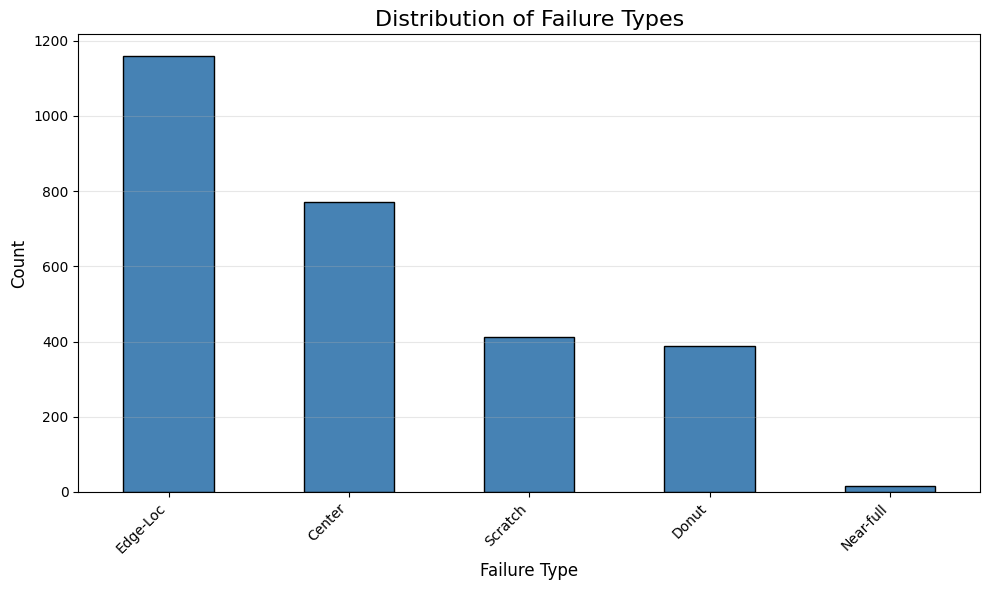

In [314]:
# TODO: inspect the failure types and the distributions, using histogram
print("Failure Type Distribution:")
print(df_train['failureType'].value_counts())
print("\nFailure Type Percentages:")
print(df_train['failureType'].value_counts(normalize=True) * 100)

# Create histogram
plt.figure(figsize=(10, 6))
df_train['failureType'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Failure Types', fontsize=16)
plt.xlabel('Failure Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [315]:
call_llm(prompt="""
In the wafer map visualizations I'm creating, I'm using matplotlib's 'viridis' colormap with vmin=0 and vmax=2 to display wafer maps.

In my code, I have these constants defined:
- NO_DIE = 0
- PASS = 1  
- FAIL = 2

When I visualize the wafer maps, I see three distinct colors:
1. Purple/dark color
2. Teal/cyan/green color
3. Yellow color

Questions for explaining this to my team:
1. What does the purple/dark color represent in the wafer map visualization?
2. What does the teal/cyan/green color represent?
3. What does the yellow color represent?
4. Why do we use these specific values (0, 1, 2) for encoding wafer map data?
5. How does the 'viridis' colormap map these numeric values to colors, and why is it a good choice for this visualization?

Please explain this in a way that would be clear to semiconductor engineers who may not be familiar with data visualization tools.
""")

Sure! Here’s a breakdown of the visualization using the 'viridis' colormap in matplotlib for your wafer maps, tailored for a semiconductor engineering audience:

### 1. What does the purple/dark color represent in the wafer map visualization?
The purple (or dark) color in the wafer map corresponds to the `NO_DIE` state (encoded as 0). This color indicates areas where there are no dies present on the wafer. Understanding this helps in quickly identifying regions of the wafer that are not being utilized for testing or production.

### 2. What does the teal/cyan/green color represent?
The teal, cyan, or green color represents the `PASS` state (encoded as 1). This indicates that the die in that area of the wafer passed the necessary tests or production criteria. It signifies good quality and functionality, showing that those dies are ready for the next steps in the manufacturing process.

### 3. What does the yellow color represent?
The yellow color corresponds to the `FAIL` state (encoded

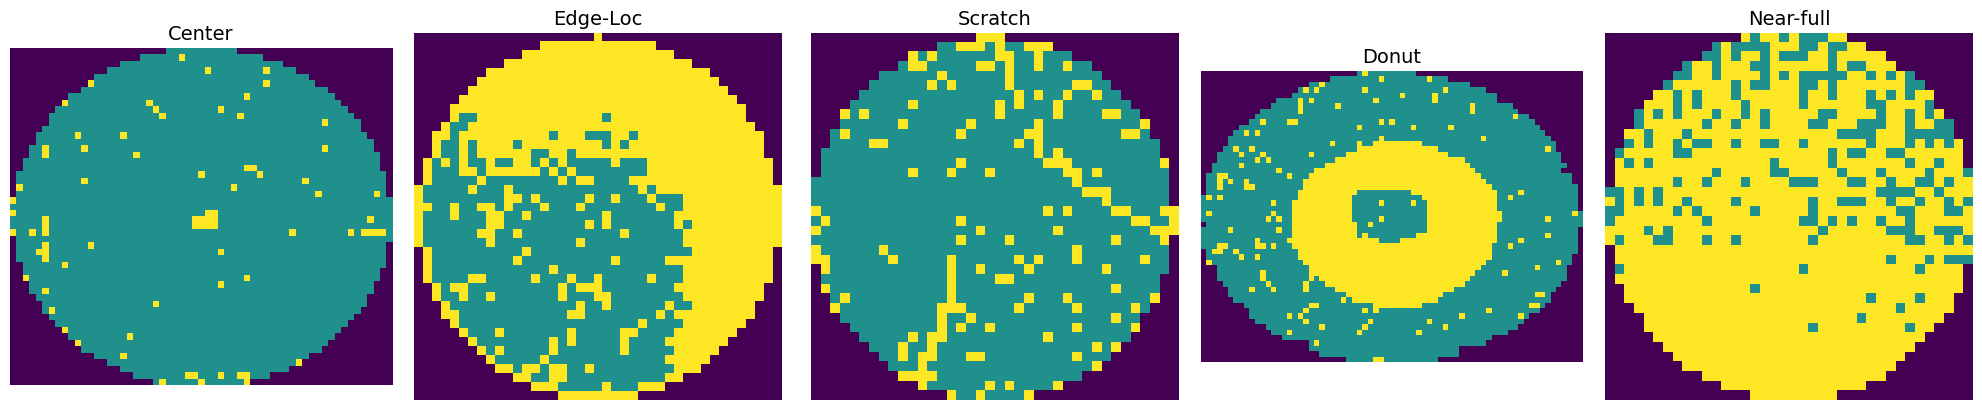

In [316]:
# TODO: show a wafermap in each class using visualize_failure_types
# Below is an example call; you should show different wafer maps than example
visualize_failure_types(df_train, figsize=(20, 4), index_off=5)

In [317]:
# Fix the output_all_wafer_maps function (iterrows returns tuple of index, row)
def output_all_wafer_maps(df: pd.DataFrame) -> None:
    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        # Get the failure type and wafer index
        failure_type = row['failureType']
        wafer_index = row['waferIndex']
        wafer_map = row['waferMap']
        
        # Create directory path based on failure type
        dir_path = f'wafer_images/{failure_type}'
        
        # Save the wafer map image
        output_image(wafer_map, str(int(wafer_index)), dir_path)
    
    return

In [318]:
# TODO: output all images to failure type directory using output_all_wafer_maps
# Note: This will create 2,746 image files organized by failure type
# It may take a few minutes to complete
print("Starting to output all wafer map images...")
print(f"Total wafer maps to save: {len(df_train)}")

# Call the function to save all images
output_all_wafer_maps(df_train)

print("\nCompleted! Images saved in the following structure:")
print("wafer_images/")
for failure_type in df_train['failureType'].unique():
    count = len(df_train[df_train['failureType'] == failure_type])
    print(f"  ├── {failure_type}/ ({count} images)")


Starting to output all wafer map images...
Total wafer maps to save: 2746

Completed! Images saved in the following structure:
wafer_images/
  ├── Center/ (771 images)
  ├── Edge-Loc/ (1159 images)
  ├── Scratch/ (413 images)
  ├── Donut/ (388 images)
  ├── Near-full/ (15 images)


In [319]:
call_llm(prompt="""
I need to create a dictionary called 'string2int' that maps failure type strings to numeric values for machine learning.

The failure types in my dataset are:
- Center
- Edge-Loc
- Scratch
- Donut
- Near-full

I need to:
1. Create a dictionary that maps each failure type string to a unique integer
2. The mapping should be consistent and deterministic
3. This will be used to convert categorical labels to numeric labels for ML models

What's the best way to create this dictionary? Should I:
- Manually assign numbers (0, 1, 2, 3, 4)?
- Use alphabetical ordering?
- Use the order they appear in the data?
- Consider any specific ordering for interpretability?

Please suggest the best approach and provide the implementation.
""")

The best approach for creating a mapping dictionary for categorical labels is to ensure that the mapping is both consistent and interpretable. Here's a commonly used method: you can manually assign numbers based on a logical order in the context of your problem, or use alphabetical ordering, depending on what makes the most sense for your application.

### Suggested Approach:
1. **Manual Assignment**: This gives you control over the mapping and allows you to assign values based on domain knowledge or importance. Since these failure types do not have a natural ordering, manually assigning them can provide clarity.

### Mapping Example
Here is a suggested mapping based on a simple manual assignment (but you can adjust this to your needs):

- Center: 0
- Edge-Loc: 1
- Scratch: 2
- Donut: 3
- Near-full: 4

This order could reflect a logical progression or importance that you determine based on your understanding of the failure types.

### Implementation
Below is the implementation of the d

For data preparation, we need to perform the following operations:
1) Resize the wafer maps as a numpy array of shape [x, 64, 64]
2) Convert the labels into numeric values

In [320]:
# TODO: Create dictionary called 'string2int' for converting string to numeric number
# Get unique failure types from the dataset to ensure we capture all types
failure_types = df_train['failureType'].unique()
print("Unique failure types:", failure_types)

# Create the string2int dictionary - mapping each failure type to a unique integer
string2int = {
    'Center': 0,
    'Donut': 1,
    'Edge-Loc': 2,
    'Near-full': 3,
    'Scratch': 4
}

print("\nstring2int dictionary:")
print(string2int)

# Verify all failure types in dataset are in the dictionary
for ft in failure_types:
    if ft not in string2int:
        print(f"Warning: '{ft}' not in string2int dictionary!")
    else:
        print(f"✓ {ft} -> {string2int[ft]}")

Unique failure types: ['Center' 'Edge-Loc' 'Scratch' 'Donut' 'Near-full']

string2int dictionary:
{'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Near-full': 3, 'Scratch': 4}
✓ Center -> 0
✓ Edge-Loc -> 2
✓ Scratch -> 4
✓ Donut -> 1
✓ Near-full -> 3


In [321]:
def convert_failure_type(failure_type: str) -> int:
    return string2int[failure_type]

def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple=(64, 64)) -> np.ndarray:
    return resize(wafer_map, output_shape, order=0, anti_aliasing=False, preserve_range=True)

In [322]:
# call_llm(prompt="""
# I need to implement a data preparation function that processes a pandas DataFrame containing wafer map data.

# Function signature:
# def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> pd.DataFrame

# The function should:
# 1. Resize all wafer maps to 64x64 using the resize_wafer_map() function
# 2. Convert failure type strings to numeric values using convert_failure_type() function
# 3. Store these as new columns in the dataframe:
#    - 'resizedWaferMap': the resized 64x64 numpy arrays
#    - 'numericFailureType': the numeric labels (only if has_labels=True)

# The DataFrame has columns:
# - 'waferMap': original numpy arrays of varying sizes
# - 'failureType': string labels (Center, Edge-Loc, Scratch, Donut, Near-full)

# Helper functions available:
# - convert_failure_type(failure_type: str) -> int: converts string to numeric using string2int dictionary
# - resize_wafer_map(wafer_map: np.ndarray, output_shape=(64,64)) -> np.ndarray: resizes wafer map

# Requirements:
# 1. Use df.apply() to apply the helper functions to each row
# 2. The has_labels parameter indicates whether the DataFrame contains failure type labels (True for training data, False for test data)
# 3. Return the modified DataFrame with new columns

# Please provide an implementation using pandas apply() method.
# """)

In [323]:
# TODO: Implement a function that creates dataframe columns to store the return values of the two tasks below using convert_failure_type and resize_wafer_map:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64)
#       (2) converts the failureType into numeric values
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> pd.DataFrame:
    # Apply resize_wafer_map to create resizedWaferMap column
    df['resizedWaferMap'] = df['waferMap'].apply(lambda wm: resize_wafer_map(wm))
    
    # Convert failure types to numeric values only if labels are present
    if has_labels:
        df['numericFailureType'] = df['failureType'].apply(convert_failure_type)
    
    return df

In [324]:
# TODO: apply prepare_data
print("Applying prepare_data to training dataframe...")
print(f"Before: {df_train.columns.tolist()}")

df_train = prepare_data(df_train, has_labels=True)

print(f"After: {df_train.columns.tolist()}")
print(f"\nVerifying new columns:")
print(f"- resizedWaferMap shape: {df_train['resizedWaferMap'].iloc[0].shape}")
print(f"- numericFailureType unique values: {sorted(df_train['numericFailureType'].unique())}")
print(f"- numericFailureType value counts:")
print(df_train['numericFailureType'].value_counts().sort_index())

Applying prepare_data to training dataframe...
Before: ['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap']
After: ['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap', 'resizedWaferMap', 'numericFailureType']

Verifying new columns:
- resizedWaferMap shape: (64, 64)
- numericFailureType unique values: [0, 1, 2, 3, 4]
- numericFailureType value counts:
numericFailureType
0     771
1     388
2    1159
3      15
4     413
Name: count, dtype: int64


In [325]:
call_llm(prompt="""
I need to implement a function that detects the "salient region" in a wafer map - the largest connected component of failing dies.

Context:
- Wafer maps are 2D numpy arrays with values: 0 (NO_DIE), 1 (PASS), 2 (FAIL)
# - I need to find all connected regions of failing dies (value = 2)
- Then select the one with the largest area (most pixels)
- Use connectivity=2 (8-connectivity: includes diagonal neighbors)

Function signature:
def get_salient_region(row: pd.Series) -> np.ndarray

The row contains:
- row['resizedWaferMap']: the 64×64 numpy array to analyze

Requirements:
1. Extract only the failing dies (value = 2) from the resized wafer map
2. Use skimage.measure.label() with connectivity=2 to identify connected components
3. Find the connected component with the largest area
4. Return a binary mask (same shape as input) where the salient region = True/1, rest = False/0

Available imports:
from skimage.measure import label, regionprops

Please provide the implementation with clear steps.
""")

Sure! To implement the function that detects the salient region in a wafer map, we can follow these steps:

1. **Extract the Failing Dies**: We'll first extract the portion of the wafer map that contains only the failing dies (where the value is 2).

2. **Label the Connected Components**: We will use the `label` function from `skimage.measure` to label the connected components of the failing dies using 8-connectivity.

3. **Calculate the Area of Each Component**: With the labeled components, we will use `regionprops` to calculate the area of each connected component.

4. **Identify the Largest Component**: We will determine which labeled region has the maximum area.

5. **Create a Binary Mask**: Finally, we will create a binary mask where the cells that belong to the largest connected component are set to `1`, and all others are set to `0`.

Here’s how you can implement `get_salient_region`:

```python
import numpy as np
import pandas as pd
from skimage.measure import label, regionprop

### STEP 2. Feature Engineering

You take a closer look at the columns in the **WM-811K** dataset and start thinking about which features could help identify **wafer map patterns**.  
To detect patterns, you’ll need **geometric information** — but none of the existing columns provide that kind of detail.  

That means you’ll have to **create your own features** directly from the `waferMap` column.  
You decide to engineer a total of **10 custom features** on your own.


In [326]:
# TODO: Implement a function that detects connected failing dies using skimage and selects "one with the largest area(=salient region)" for each wafer map
# Hint: use connectivity=2

def get_salient_region(row: pd.Series) -> np.ndarray:
    # Get the resized wafer map
    wafer_map = row['resizedWaferMap']
    
    # Create binary mask of failing dies (value = 2)
    fail_mask = (wafer_map == FAIL).astype(int)
    
    # Label connected components with 8-connectivity (connectivity=2)
    labeled_regions = label(fail_mask, connectivity=2)
    
    # If no failing dies, return empty mask
    if labeled_regions.max() == 0:
        return np.zeros_like(wafer_map, dtype=int)
    
    # Get properties of all regions
    regions = regionprops(labeled_regions)
    
    # Find the region with the largest area
    largest_region = max(regions, key=lambda r: r.area)
    
    # Create binary mask for the salient region
    salient_region = (labeled_regions == largest_region.label).astype(int)
    
    return salient_region

In [327]:
# TODO: Apply get_salient_region to the dataframe and save the results to a new column, and check if the dataframe has new column "salientRegion"
print("Applying get_salient_region to extract largest connected failure regions...")
df_train['salientRegion'] = df_train.apply(get_salient_region, axis=1)

print(f"✓ Column 'salientRegion' added to dataframe")
print(f"Columns: {df_train.columns.tolist()}")
print(f"\nSample salient region shape: {df_train['salientRegion'].iloc[0].shape}")
print(f"Sample salient region unique values: {np.unique(df_train['salientRegion'].iloc[0])}")

Applying get_salient_region to extract largest connected failure regions...
✓ Column 'salientRegion' added to dataframe
Columns: ['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap', 'resizedWaferMap', 'numericFailureType', 'salientRegion']

Sample salient region shape: (64, 64)
Sample salient region unique values: [0 1]


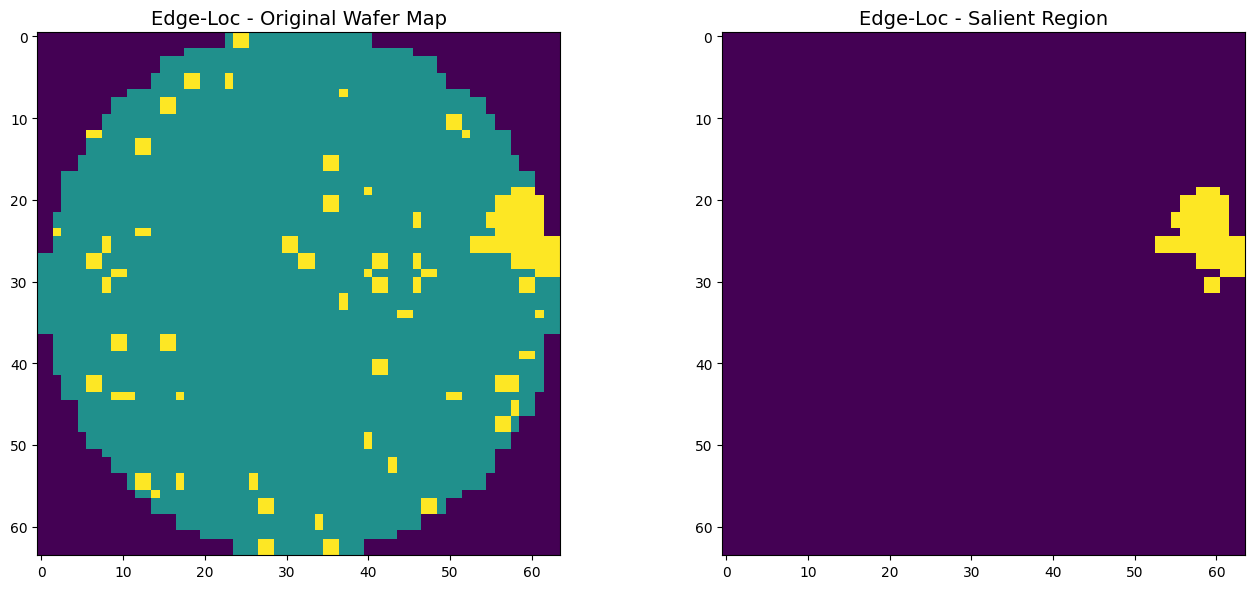

In [328]:
# TODO: Verify the salient region
# Below is an example call; you should show different wafer maps than example
failure_type = 'Edge-Loc'
row_index = 0

row = df_train.loc[df_train['failureType'] == failure_type].iloc[row_index]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Show original resized wafer map with axis labels
axes[0].imshow(row['resizedWaferMap'], cmap='viridis', vmin=0, vmax=2)
axes[0].set_title(f'{failure_type} - Original Wafer Map', fontsize=14)

# Show salient region (largest connected failure component) with axis labels
axes[1].imshow(row['salientRegion'], cmap='viridis', vmin=0, vmax=1)
axes[1].set_title(f'{failure_type} - Salient Region', fontsize=14)

plt.tight_layout()
plt.show()

In [329]:
call_llm(prompt="""
I need to implement geometric feature extraction functions for wafer map failure pattern classification.

Starting with get_area_ratio() function:

Function signature:
def get_area_ratio(row: pd.Series) -> float

Context:
- row['salientRegion']: 64×64 binary numpy array (1 = salient region, 0 = background)
- row['resizedWaferMap']: 64×64 numpy array with values 0 (NO_DIE), 1 (PASS), 2 (FAIL)

Task: Calculate the ratio of the area of the salient region to the total area of the wafer (excluding NO_DIE locations)

Questions:
1. How do I calculate the area of the salient region? (count of pixels with value 1)
2. How do I calculate the total wafer area? (count of all dies, excluding NO_DIE locations)
3. What should I return if there are no dies on the wafer (edge case)?

Please provide the implementation with clear variable names.
""")

Certainly! Below is the implementation of the `get_area_ratio` function based on your specifications.

### Explanation of the Implementation

1. **Area of the Salient Region**: This can be computed by counting the number of pixels in `row['salientRegion']` that are equal to 1 (i.e., the salient region).
2. **Total Wafer Area**: This is determined by counting the pixels in `row['resizedWaferMap']` that are either 1 (PASS) or 2 (FAIL). These represent the dies that are present on the wafer.
3. **Edge Case Handling**: If there are no dies (i.e., the total area is 0), we can return 0 as the area ratio to handle this situation gracefully.

Here’s the implementation:

```python
import numpy as np
import pandas as pd

def get_area_ratio(row: pd.Series) -> float:
    # Calculate the area of the salient region
    salient_area = np.sum(row['salientRegion'] == 1)

    # Calculate the total area of the wafer (excluding NO_DIE locations)
    total_area = np.sum((row['resizedWaferMap'] == 1) | (row

In [330]:
# TODO: Implement a function that returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    # Get the salient region and wafer map
    salient_region = row['salientRegion']
    wafer_map = row['resizedWaferMap']
    
    # Calculate area of salient region (count of 1s)
    salient_area = np.sum(salient_region)
    
    # Calculate total wafer area (all dies: PASS + FAIL, excluding NO_DIE)
    total_wafer_area = np.sum((wafer_map == PASS) | (wafer_map == FAIL))
    
    # Handle edge case where there are no dies
    if total_wafer_area == 0:
        return 0.0
    
    # Calculate and return the ratio
    area_ratio = salient_area / total_wafer_area
    
    return area_ratio

In [331]:
# Test get_area_ratio on a sample
test_row = df_train.iloc[0]
area_ratio_result = get_area_ratio(test_row)
print(f"Sample area ratio: {area_ratio_result:.4f}")
print(f"Failure type: {test_row['failureType']}")
print(f"Salient region area: {np.sum(test_row['salientRegion'])} pixels")
print(f"Total wafer area: {np.sum((test_row['resizedWaferMap'] == PASS) | (test_row['resizedWaferMap'] == FAIL))} dies")

Sample area ratio: 0.0380
Failure type: Center
Salient region area: 124 pixels
Total wafer area: 3267 dies


In [332]:
call_llm(prompt="""
I need to implement get_perimeter_ratio() function for wafer map failure pattern classification.

Function signature:
def get_perimeter_ratio(row: pd.Series) -> float

Context:
- row['salientRegion']: 64×64 binary numpy array (1 = salient region, 0 = background)
- row['resizedWaferMap']: 64×64 numpy array
- The wafer is circular, and we need to calculate its radius

Task: Calculate the ratio of the perimeter of the salient region to the radius of the wafer

Questions:
1. How do I calculate the perimeter of the salient region using skimage?
2. How do I estimate the radius of the wafer? (hint: wafer is circular, radius ≈ sqrt(total_wafer_area/π))
3. What should I return if the radius is 0 (edge case)?
4. Should I use skimage.measure.perimeter() for calculating the perimeter?

Please provide the implementation with clear steps.
""")

To implement the `get_perimeter_ratio` function for wafer map failure pattern classification, we will follow a series of steps. Here's how we will implement it based on your questions:

1. **Calculate the perimeter of the salient region**: We can use `skimage.measure.perimeter()` for this purpose. This function calculates the perimeter of a binary object. We will pass the binary array (the salient region) to this function.

2. **Estimate the radius of the wafer**: Since the wafer is circular, we can estimate the radius using the area of the wafer. The total area occupied by the wafer can be found by counting the number of pixels in the `resizedWaferMap` that are non-zero (or summing the pixel values if it is normalized). The formula for the radius from the area is given by:
   \[
   \text{radius} = \sqrt{\frac{\text{total\_wafer\_area}}{\pi}}
   \]

3. **Handling the edge case**: If the calculated radius is 0, the ratio is undefined, and we should return `float('inf')`, which indicates

In [333]:
# TODO: Implement a function that returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    # Get the salient region and wafer map
    salient_region = row['salientRegion']
    wafer_map = row['resizedWaferMap']
    
    # Calculate perimeter of the salient region using skimage
    salient_perimeter = perimeter(salient_region)
    
    # Calculate total wafer area to estimate radius
    total_wafer_area = np.sum((wafer_map == PASS) | (wafer_map == FAIL))
    
    # Handle edge case where there are no dies
    if total_wafer_area == 0:
        return 0.0
    
    # Estimate wafer radius assuming circular shape: area = π * r^2, so r = sqrt(area/π)
    wafer_radius = np.sqrt(total_wafer_area / np.pi)
    
    # Calculate and return the ratio
    perimeter_ratio = salient_perimeter / wafer_radius
    
    return perimeter_ratio

In [334]:
# Test get_perimeter_ratio on a sample
test_row = df_train.iloc[0]
perimeter_ratio_result = get_perimeter_ratio(test_row)
print(f"Sample perimeter ratio: {perimeter_ratio_result:.4f}")
print(f"Failure type: {test_row['failureType']}")

# Calculate details for understanding
total_area = np.sum((test_row['resizedWaferMap'] == PASS) | (test_row['resizedWaferMap'] == FAIL))
estimated_radius = np.sqrt(total_area / np.pi)
salient_perimeter = perimeter(test_row['salientRegion'])
print(f"Salient region perimeter: {salient_perimeter:.2f} pixels")
print(f"Estimated wafer radius: {estimated_radius:.2f} pixels")

Sample perimeter ratio: 2.4393
Failure type: Center
Salient region perimeter: 78.66 pixels
Estimated wafer radius: 32.25 pixels


In [335]:
call_llm(prompt="""
I need to implement distance-based features for wafer map failure pattern classification.

Two functions to implement:
1. get_max_dist_from_center(row: pd.Series) -> float
2. get_min_dist_from_center(row: pd.Series) -> float

Context:
- row['salientRegion']: 64×64 binary numpy array (1 = salient region, 0 = background)
- row['resizedWaferMap']: 64×64 numpy array
- Wafer is circular, centered in the image

Tasks:
1. Find the center of the wafer map (approximately at position (32, 32) for 64×64 array)
2. For all pixels in the salient region, calculate their Euclidean distance from center
3. Return the maximum distance (for get_max_dist_from_center)
4. Return the minimum distance (for get_min_dist_from_center)

Questions:
1. How do I find all coordinates where salientRegion == 1?
2. How do I calculate Euclidean distance from center for each coordinate?
3. What should I return if salient region is empty (no failing dies)?
4. Should I normalize by wafer radius?

Please provide implementations with clear variable names and comments.
""")

Certainly! Below is the implementation of the two required functions, `get_max_dist_from_center` and `get_min_dist_from_center`, as you described. The implementation also addresses the questions you posed.

### Implementation

```python
import pandas as pd
import numpy as np

def get_max_dist_from_center(row: pd.Series) -> float:
    """
    Calculates the maximum distance from the center of the wafer for salient pixels.

    Parameters:
    row (pd.Series): A row from a DataFrame that contains 'salientRegion' and 'resizedWaferMap'.

    Returns:
    float: The maximum distance from the center to a salient pixel.
    """
    # Define the center of the wafer (for a 64x64 image)
    center_x, center_y = 32, 32
    
    # Get the binary salient region
    salient_region = row['salientRegion']
    
    # Find all indices (coordinates) where salientRegion is 1
    salient_coords = np.argwhere(salient_region == 1)
    
    # If no salient pixels exist, return 0 as a convention
    if salient

In [336]:
# TODO: Implement a function that returns the maximal distance between the salient region and the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    # Get the salient region
    salient_region = row['salientRegion']
    
    # Find all coordinates where salient region exists
    coords = np.argwhere(salient_region == 1)
    
    # If no salient region, return 0
    if len(coords) == 0:
        return 0.0
    
    # Calculate center of the wafer map (64x64 image, center at (31.5, 31.5))
    center_y, center_x = 31.5, 31.5
    
    # Calculate Euclidean distance from center for each coordinate
    distances = np.sqrt((coords[:, 0] - center_y)**2 + (coords[:, 1] - center_x)**2)
    
    # Get maximum distance (in pixels)
    max_distance = np.max(distances)
    
    return max_distance

In [337]:
# TODO: Implement a function that returns the minimal distance between the salient region and the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    # Get the salient region
    salient_region = row['salientRegion']
    
    # Find all coordinates where salient region exists
    coords = np.argwhere(salient_region == 1)
    
    # If no salient region, return 0
    if len(coords) == 0:
        return 0.0
    
    # Calculate center of the wafer map (64x64 image, center at (31.5, 31.5))
    center_y, center_x = 31.5, 31.5
    
    # Calculate Euclidean distance from center for each coordinate
    distances = np.sqrt((coords[:, 0] - center_y)**2 + (coords[:, 1] - center_x)**2)
    
    # Get minimum distance (in pixels)
    min_distance = np.min(distances)
    
    return min_distance

In [338]:
# Test distance functions on samples from different failure types
test_cases = [
    ('Center', 0),
    ('Edge-Loc', 0),
    ('Donut', 0)
]

for failure_type, idx in test_cases:
    row = df_train.loc[df_train['failureType'] == failure_type].iloc[idx]
    max_dist = get_max_dist_from_center(row)
    min_dist = get_min_dist_from_center(row)
    print(f"{failure_type}:")
    print(f"  Max distance from center: {max_dist:.4f}")
    print(f"  Min distance from center: {min_dist:.4f}")
    print(f"  Difference: {max_dist - min_dist:.4f}")
    print()

Center:
  Max distance from center: 12.7475
  Min distance from center: 0.7071
  Difference: 12.0404

Edge-Loc:
  Max distance from center: 32.1636
  Min distance from center: 22.1923
  Difference: 9.9713

Donut:
  Max distance from center: 30.2076
  Min distance from center: 5.5227
  Difference: 24.6849



In [339]:
call_llm(prompt="""
I'm implementing distance-based features for wafer map classification and normalizing them by wafer_radius.

In my code:
```python
wafer_radius = np.sqrt(total_wafer_area / np.pi)
normalized_distance = distance / wafer_radius
```

Questions for explaining to my team:

1. Why normalize distances by wafer radius instead of using raw pixel distances?

2. What problems occur if we use absolute pixel distances instead of normalized ratios?

3. Wafer maps come from different die sizes and wafer sizes - how does normalization handle this variability?

4. What does a normalized distance represent? If max_dist_from_center = 1.0, what does that mean?

5. How does normalization make features "scale-invariant" for machine learning?

6. Looking at our test results:
   - Center: max=0.40, min=0.02
   - Edge-Loc: max=1.01, min=0.70
   - Donut: max=0.95, min=0.17
   
   How do these normalized values help distinguish patterns better than raw pixel distances would?

Please explain for both semiconductor engineers and ML practitioners.
""")

Certainly! Let’s break down your questions about normalizing distances for wafer maps in a way that will resonate with both semiconductor engineers and machine learning (ML) practitioners.

### 1. Why normalize distances by wafer radius instead of using raw pixel distances?

**For Semiconductor Engineers**: Normalizing by wafer radius helps us to relate distances to the physical boundaries of the wafer. Each wafer may have different radii, so using raw pixel distances could lead to inconsistent interpretations of how far a feature is from the center. 

**For ML Practitioners**: Normalizing distances ensures that the feature input spaces are consistent across different samples. This prevents the model from misinterpreting the significance of raw distances, which can vary widely between different wafers.

### 2. What problems occur if we use absolute pixel distances instead of normalized ratios?

**For Semiconductor Engineers**: Raw pixel distances can be misleading since they don’t acco

In [340]:
call_llm(prompt="""
I need to implement get_major_axis_ratio() and get_minor_axis_ratio() functions for wafer map failure pattern classification.

Function signatures:
def get_major_axis_ratio(row: pd.Series) -> float
def get_minor_axis_ratio(row: pd.Series) -> float

Context:
- row['salientRegion']: 64×64 binary numpy array (1 = salient region, 0 = background)
- row['resizedWaferMap']: 64×64 numpy array
- I have access to skimage.measure.regionprops which can fit an ellipse to the region

Task: Calculate the ratio of the major/minor axis length of the fitted ellipse to the wafer radius

Questions for explaining to my team:
1. What do major axis and minor axis represent in terms of the failure pattern shape?
2. How does regionprops fit an ellipse to a binary region? What properties does it provide?
3. How do I use regionprops to get major_axis_length and minor_axis_length?
4. Why normalize by wafer radius (similar to distance features)?
5. What do these ratios tell us about different failure patterns? For example:
   - Would a Scratch pattern have high major_axis_ratio and low minor_axis_ratio?
   - Would a Center pattern have similar major and minor axis ratios?
6. What should I return if the salient region is empty?

Please provide implementation guidance with clear steps.
""")

To implement the `get_major_axis_ratio()` and `get_minor_axis_ratio()` functions for wafer map failure pattern classification, let's first clarify the necessary concepts and steps.

### 1. Understanding Major and Minor Axes
- **Major Axis**: This represents the longest diameter of the fitted ellipse over the salient regions. It is a significant indicator of the elongation of the failure pattern.
- **Minor Axis**: This represents the shortest diameter of the fitted ellipse. It provides insights into how "thin" or "wide" the failure pattern appears.

### 2. Region Properties with `regionprops`
The `regionprops` function from `skimage.measure` computes various properties of labeled regions in binary images. For our case:
- Regionprops can fit an ellipse to the binary region, providing properties such as:
  - `major_axis_length`: The length of the major axis of the fitted ellipse.
  - `minor_axis_length`: The length of the minor axis of the fitted ellipse.

### 3. Using `regionprops` to Ge

In [341]:
# TODO: Implement a function that returns the ratio of the length of the major axis of the estimated ellipse surrounding the salient region to the radius of the wafer map
def get_major_axis_ratio(row: pd.Series) -> float:
    # Get the salient region and wafer map
    salient_region = row['salientRegion']
    wafer_map = row['resizedWaferMap']
    
    # Label the salient region to get region properties
    labeled_region = label(salient_region)
    
    # If no salient region, return 0
    if labeled_region.max() == 0:
        return 0.0
    
    # Get region properties
    regions = regionprops(labeled_region)
    
    # Get the major axis length from the first (and only) region
    major_axis_length = regions[0].major_axis_length
    
    # Calculate wafer radius for normalization
    total_wafer_area = np.sum((wafer_map == PASS) | (wafer_map == FAIL))
    if total_wafer_area == 0:
        return 0.0
    wafer_radius = np.sqrt(total_wafer_area / np.pi)
    
    # Calculate and return the ratio
    major_axis_ratio = major_axis_length / wafer_radius
    
    return major_axis_ratio

In [342]:
# TODO: Implement a function that returns the ratio of the length of the minor axis of the estimated ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    # Get the salient region and wafer map
    salient_region = row['salientRegion']
    wafer_map = row['resizedWaferMap']
    
    # Label the salient region to get region properties
    labeled_region = label(salient_region)
    
    # If no salient region, return 0
    if labeled_region.max() == 0:
        return 0.0
    
    # Get region properties
    regions = regionprops(labeled_region)
    
    # Get the minor axis length from the first (and only) region
    minor_axis_length = regions[0].minor_axis_length
    
    # Calculate wafer radius for normalization
    total_wafer_area = np.sum((wafer_map == PASS) | (wafer_map == FAIL))
    if total_wafer_area == 0:
        return 0.0
    wafer_radius = np.sqrt(total_wafer_area / np.pi)
    
    # Calculate and return the ratio
    minor_axis_ratio = minor_axis_length / wafer_radius
    
    return minor_axis_ratio

In [343]:
# TODO: Implement a function that returns the solidity, indicating the proportion of defective dies in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    # Get the salient region
    salient_region = row['salientRegion']
    
    # Label the salient region to get region properties
    labeled_region = label(salient_region)
    
    # If no salient region, return 0
    if labeled_region.max() == 0:
        return 0.0
    
    # Get region properties
    regions = regionprops(labeled_region)
    
    # Get the solidity from the first (and only) region
    # Solidity = area / convex_area (ratio of region area to its convex hull area)
    # Values close to 1 indicate compact shapes, lower values indicate irregular shapes
    solidity = regions[0].solidity
    
    return solidity

In [344]:
# TODO: Implement a function that returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    # Get the salient region
    salient_region = row['salientRegion']
    
    # Label the salient region to get region properties
    labeled_region = label(salient_region)
    
    # If no salient region, return 0
    if labeled_region.max() == 0:
        return 0.0
    
    # Get region properties
    regions = regionprops(labeled_region)
    
    # Get the eccentricity from the first (and only) region
    # Eccentricity ranges from 0 (circle) to 1 (line segment)
    eccentricity = regions[0].eccentricity
    
    return eccentricity

In [345]:
# TODO: Implement a function that returns the ratio of the failed dies on the wafer map to the total number of dies on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    # Get the resized wafer map
    wafer_map = row['resizedWaferMap']
    
    # Count failed dies (value = 2)
    failed_dies = np.sum(wafer_map == FAIL)
    
    # Count total dies (PASS + FAIL, excluding NO_DIE)
    total_dies = np.sum((wafer_map == PASS) | (wafer_map == FAIL))
    
    # Handle edge case where there are no dies
    if total_dies == 0:
        return 0.0
    
    # Calculate yield loss (failure rate)
    yield_loss = failed_dies / total_dies
    
    return yield_loss

In [346]:
# Test get_yield_loss on samples from different failure types
test_cases = [
    ('Center', 0),
    ('Near-full', 0),
    ('Scratch', 0)
]

for failure_type, idx in test_cases:
    row = df_train.loc[df_train['failureType'] == failure_type].iloc[idx]
    yield_loss_val = get_yield_loss(row)
    print(f"{failure_type}:")
    print(f"  Yield loss: {yield_loss_val:.4f} ({yield_loss_val*100:.2f}%)")
    print()

Center:
  Yield loss: 0.0744 (7.44%)

Near-full:
  Yield loss: 0.8645 (86.45%)

Scratch:
  Yield loss: 0.0183 (1.83%)



In [347]:
call_llm(prompt="""
I need to implement the final geometric feature for wafer map classification: edge yield loss.

Two functions to implement:
1. ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray: Helper function
2. get_edge_yield_loss(row: pd.Series) -> float: Main feature function

Context:
- Edge-Loc failure patterns have failures concentrated at the wafer edges
- Need to identify the outermost two rings of dies on the wafer
- Calculate yield loss specifically for those edge rings

Questions for explaining to my team:

1. Why is edge yield loss important for distinguishing Edge-Loc patterns from other failure types?

2. How do I identify the "outermost two rings" of a circular wafer using morphological operations?
   - Should I use erosion or dilation?
   - What structuring element should I use?

3. Algorithm for ring_label_from_outside():
   - Start with binary mask of all dies (PASS + FAIL)
   - Apply erosion once to peel off outer ring
   - Subtract to get ring 1
   - Apply erosion again to get ring 2
   - Combine both rings

4. For get_edge_yield_loss():
   - Use ring mask from helper function
   - Count failed dies within the ring mask
   - Count total dies within the ring mask
   - Return ratio

5. How will this feature help distinguish:
   - Edge-Loc: High edge yield loss
   - Center: Low edge yield loss
   - Donut: Moderate edge yield loss
   - Near-full: High edge yield loss (but also high overall yield loss)
   - Scratch: Depends on scratch location

Please provide implementation guidance.
""")

Certainly! Let's break down your implementation and explanation needs step by step:

### 1. Importance of Edge Yield Loss

**Why is edge yield loss important for distinguishing Edge-Loc patterns from other failure types?**

Edge yield loss is critical because:
- **Concentration of Failures:** Edge-Loc patterns specifically show concentrated failures at the edges of the wafer. Understanding yield loss in these areas helps distinguish them from other failure types that may have failures distributed more evenly.
- **Process Improvement:** By identifying edge failures, you can refine processing parameters or materials that may contribute to such defects, leading to overall yield improvements.
- **Quality Control:** Differentiating between edge-related failures and central failures can guide better quality control strategies and maintenance of manufacturing equipment.

### 2. Identification of Outermost Two Rings using Morphological Operations

To identify the outermost two rings of dies:
-

In [348]:
# TODO: Implement a function that returns the ratio of the failed dies on the outermost two rings of the wafer map to the total number of dies on the outermost two rings of the wafer map
# Use ring_label_from_outside helper function
def get_edge_yield_loss(row: pd.Series) -> float:
    # Get the resized wafer map
    wafer_map = row['resizedWaferMap']
    
    # Get the ring mask highlighting the outermost two rings
    ring_mask = ring_label_from_outside(wafer_map)
    
    # Count failed dies in the edge rings
    edge_failed_dies = np.sum((wafer_map == FAIL) & (ring_mask > 0))
    
    # Count total dies in the edge rings (PASS + FAIL)
    edge_total_dies = np.sum(((wafer_map == PASS) | (wafer_map == FAIL)) & (ring_mask > 0))
    
    # Handle edge case where there are no dies in the edge rings
    if edge_total_dies == 0:
        return 0.0
    
    # Calculate edge yield loss (failure rate on edge)
    edge_yield_loss = edge_failed_dies / edge_total_dies
    
    return edge_yield_loss


# TODO: Implement a helper function that returns a numpy array highlighting the outermost two rings of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    from skimage.morphology import binary_erosion, square
    
    # Create a binary mask of all dies (PASS + FAIL, excluding NO_DIE)
    die_mask = ((wafer_map == PASS) | (wafer_map == FAIL)).astype(int)
    
    # If no dies, return empty array
    if die_mask.sum() == 0:
        return np.zeros_like(wafer_map, dtype=int)
    
    # Erode the die mask once to remove the outermost ring
    eroded_once = binary_erosion(die_mask, square(3)).astype(int)
    
    # Get the first ring (outermost)
    ring_1 = die_mask - eroded_once
    
    # Erode again to remove the second outermost ring
    eroded_twice = binary_erosion(eroded_once, square(3)).astype(int)
    
    # Get the second ring
    ring_2 = eroded_once - eroded_twice
    
    # Combine both rings (1 for ring 1, 2 for ring 2, or just mark as 1 for any ring)
    ring_labels = (ring_1 + ring_2).astype(int)
    
    return ring_labels

Edge-Loc: Edge yield loss = 0.1082 (10.82%)
Center: Edge yield loss = 0.0407 (4.07%)
Donut: Edge yield loss = 0.1084 (10.84%)


/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:38: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_once = binary_erosion(die_mask, square(3)).astype(int)
/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:44: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_twice = binary_erosion(eroded_once, square(3)).astype(int)


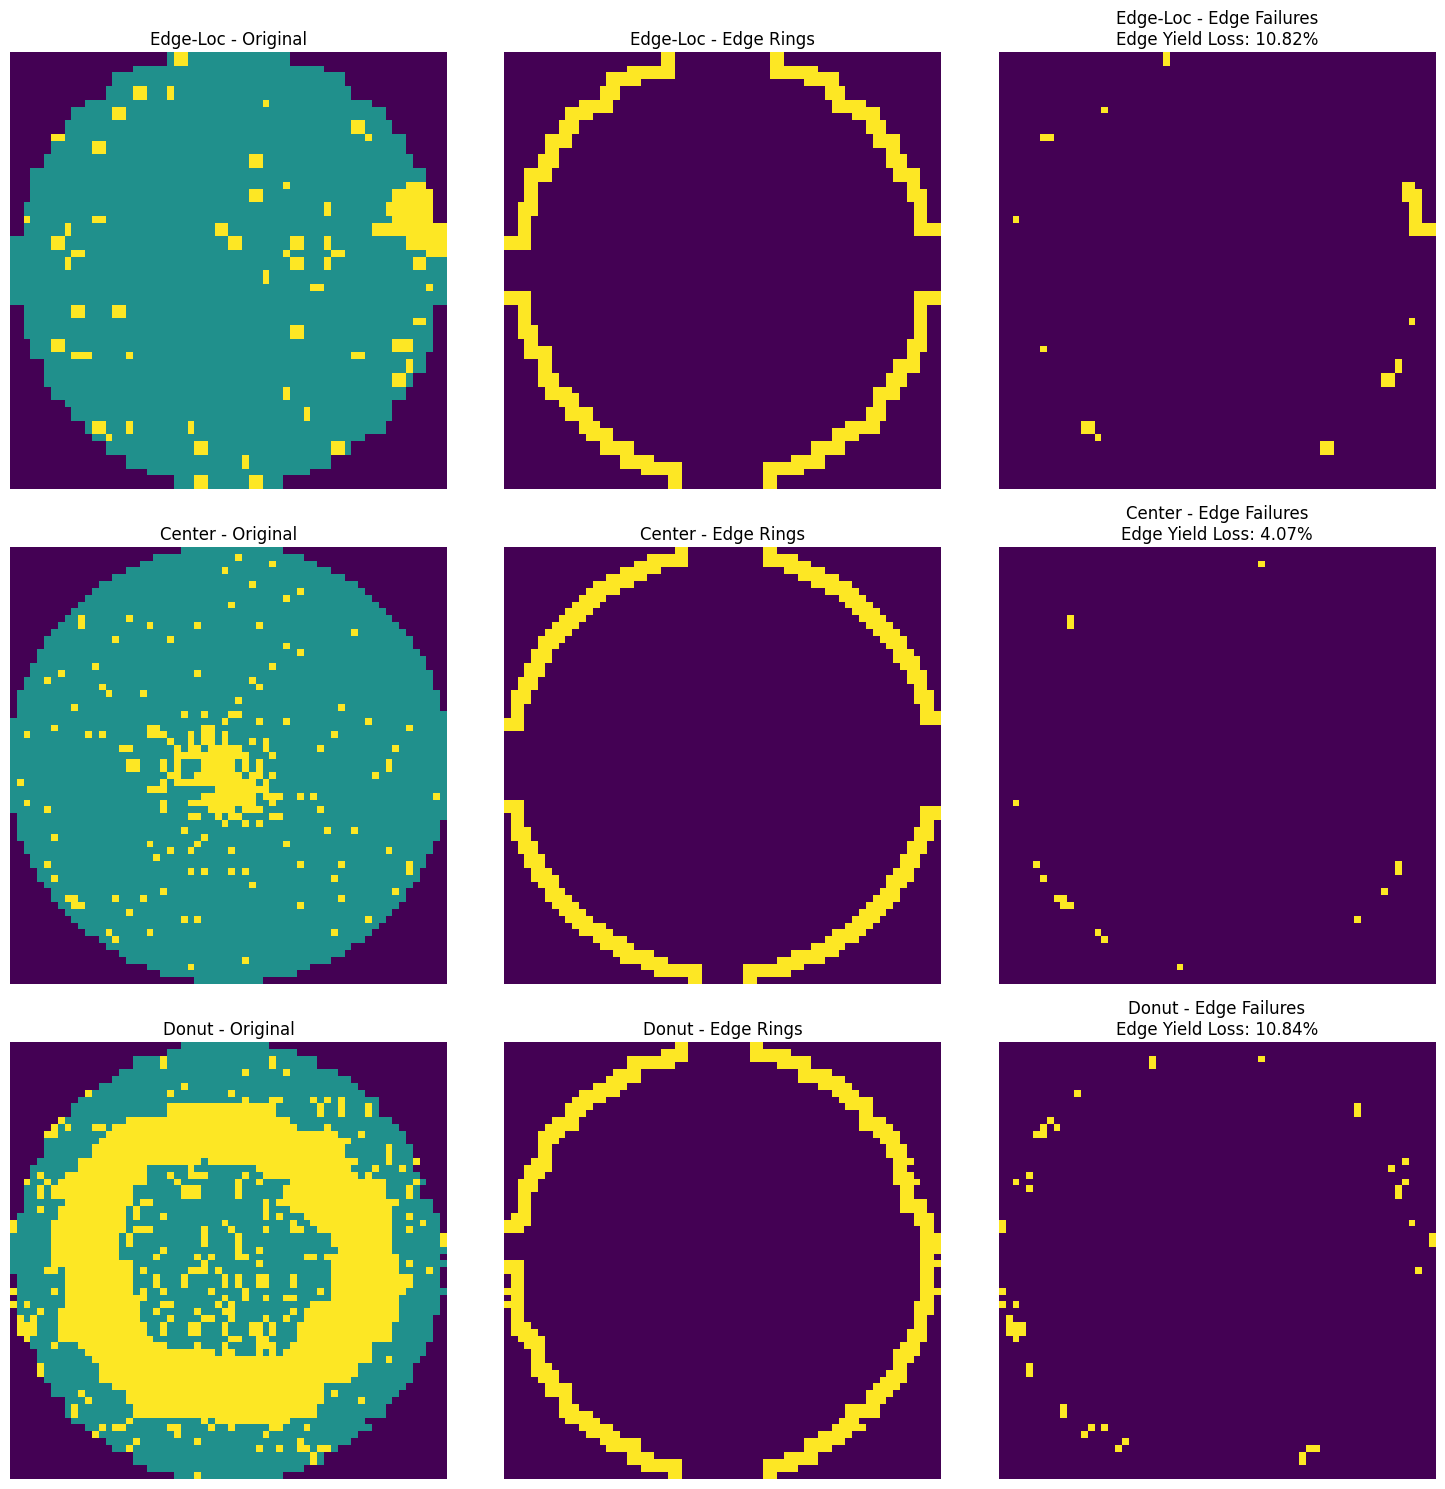

In [349]:
# Test edge_yield_loss and ring_label_from_outside on different failure types
test_cases = [
    ('Edge-Loc', 0),
    ('Center', 0),
    ('Donut', 0)
]

fig, axes = plt.subplots(len(test_cases), 3, figsize=(15, 5*len(test_cases)))

for i, (failure_type, idx) in enumerate(test_cases):
    row = df_train.loc[df_train['failureType'] == failure_type].iloc[idx]
    edge_yield_loss_val = get_edge_yield_loss(row)
    ring_mask = ring_label_from_outside(row['resizedWaferMap'])
    
    # Show original wafer map
    axes[i, 0].imshow(row['resizedWaferMap'], cmap='viridis', vmin=0, vmax=2)
    axes[i, 0].set_title(f'{failure_type} - Original', fontsize=12)
    axes[i, 0].axis('off')
    
    # Show ring mask
    axes[i, 1].imshow(ring_mask, cmap='viridis')
    axes[i, 1].set_title(f'{failure_type} - Edge Rings', fontsize=12)
    axes[i, 1].axis('off')
    
    # Show edge failures highlighted
    edge_failures = (row['resizedWaferMap'] == FAIL) & (ring_mask > 0)
    axes[i, 2].imshow(edge_failures, cmap='viridis')
    axes[i, 2].set_title(f'{failure_type} - Edge Failures\nEdge Yield Loss: {edge_yield_loss_val:.2%}', fontsize=12)
    axes[i, 2].axis('off')
    
    print(f"{failure_type}: Edge yield loss = {edge_yield_loss_val:.4f} ({edge_yield_loss_val*100:.2f}%)")

plt.tight_layout()
plt.show()

In [350]:
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:

    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)

    return df

In [351]:
# TODO: Apply create_feature_columns on the training dataframe
print("Applying feature extraction to all training samples...")
print(f"Total samples: {len(df_train)}")
print(f"This will compute 10 geometric features for each sample.")
print(f"Features: areaRatio, perimeterRatio, maxDistFromCenter, minDistFromCenter,")
print(f"          majorAxisRatio, minorAxisRatio, solidity, eccentricity,")
print(f"          yieldLoss, edgeYieldLoss")
print("\nThis may take a minute or two...")

df_train = create_feature_columns(df_train)

print("\n✓ Feature extraction complete!")
print(f"New columns added: {df_train.columns.tolist()[-10:]}")
print(f"\nDataFrame now has {len(df_train.columns)} columns")

# Display sample of extracted features
print("\nSample feature values (first 3 rows):")
feature_cols = ['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter',
                'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
                'yieldLoss', 'edgeYieldLoss']
print(df_train[feature_cols].head(3))

Applying feature extraction to all training samples...
Total samples: 2746
This will compute 10 geometric features for each sample.
Features: areaRatio, perimeterRatio, maxDistFromCenter, minDistFromCenter,
          majorAxisRatio, minorAxisRatio, solidity, eccentricity,
          yieldLoss, edgeYieldLoss

This may take a minute or two...


/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:38: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_once = binary_erosion(die_mask, square(3)).astype(int)
/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:44: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_twice = binary_erosion(eroded_once, square(3)).astype(int)



✓ Feature extraction complete!
New columns added: ['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter', 'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity', 'yieldLoss', 'edgeYieldLoss']

DataFrame now has 19 columns

Sample feature values (first 3 rows):
   areaRatio  perimeterRatio  maxDistFromCenter  minDistFromCenter  \
0   0.037955        2.439330          12.747549           0.707107   
1   0.012218        0.880648           5.147815           0.707107   
2   0.004052        0.358306           2.915476           0.707107   

   majorAxisRatio  minorAxisRatio  solidity  eccentricity  yieldLoss  \
0        0.600985        0.367385  0.566210      0.791395   0.074380   
1        0.296572        0.225342  0.709091      0.650130   0.097118   
2        0.202940        0.112205  0.684211      0.833249   0.040835   

   edgeYieldLoss  
0       0.040670  
1       0.180288  
2       0.095890  


Area Ratio:           0.038
Max Dist from Center: 12.748
Min Dist from Center: 0.707
Perimeter Ratio:      2.439
Major Axis Ratio:     0.601
Minor Axis Ratio:     0.367
Solidity:             0.566
Eccentricity:         0.791
Yield Loss:           0.074
Edge Yield Loss:      0.041


/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:38: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_once = binary_erosion(die_mask, square(3)).astype(int)
/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:44: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_twice = binary_erosion(eroded_once, square(3)).astype(int)


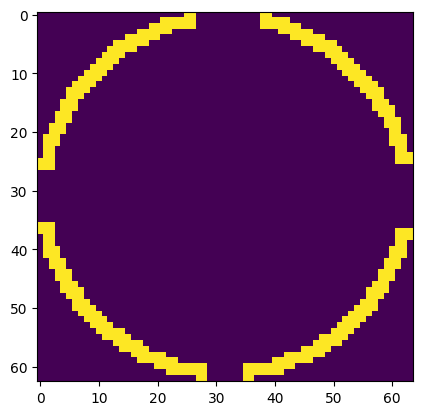

In [352]:
# TODO: Verify feature functions
# Below is an example call; you should show different wafer maps than example

failure_type = 'Center'
row_index = 0
row = df_train.loc[df_train['failureType']==failure_type].iloc[row_index]

print("Area Ratio:          ", f'{get_area_ratio(row):.3f}')
print("Max Dist from Center:", f'{get_max_dist_from_center(row):.3f}')
print("Min Dist from Center:", f'{get_min_dist_from_center(row):.3f}')
print("Perimeter Ratio:     ", f'{get_perimeter_ratio(row):.3f}')
print("Major Axis Ratio:    ", f'{get_major_axis_ratio(row):.3f}')
print("Minor Axis Ratio:    ", f'{get_minor_axis_ratio(row):.3f}')
print("Solidity:            ", f'{get_solidity(row):.3f}')
print("Eccentricity:        ", f'{get_eccentricity(row):.3f}')
print("Yield Loss:          ", f'{get_yield_loss(row):.3f}')
print("Edge Yield Loss:     ", f'{get_edge_yield_loss(row):.3f}')

plt.imshow(ring_label_from_outside(row['waferMap']))

/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:38: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_once = binary_erosion(die_mask, square(3)).astype(int)
/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:44: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_twice = binary_erosion(eroded_once, square(3)).astype(int)


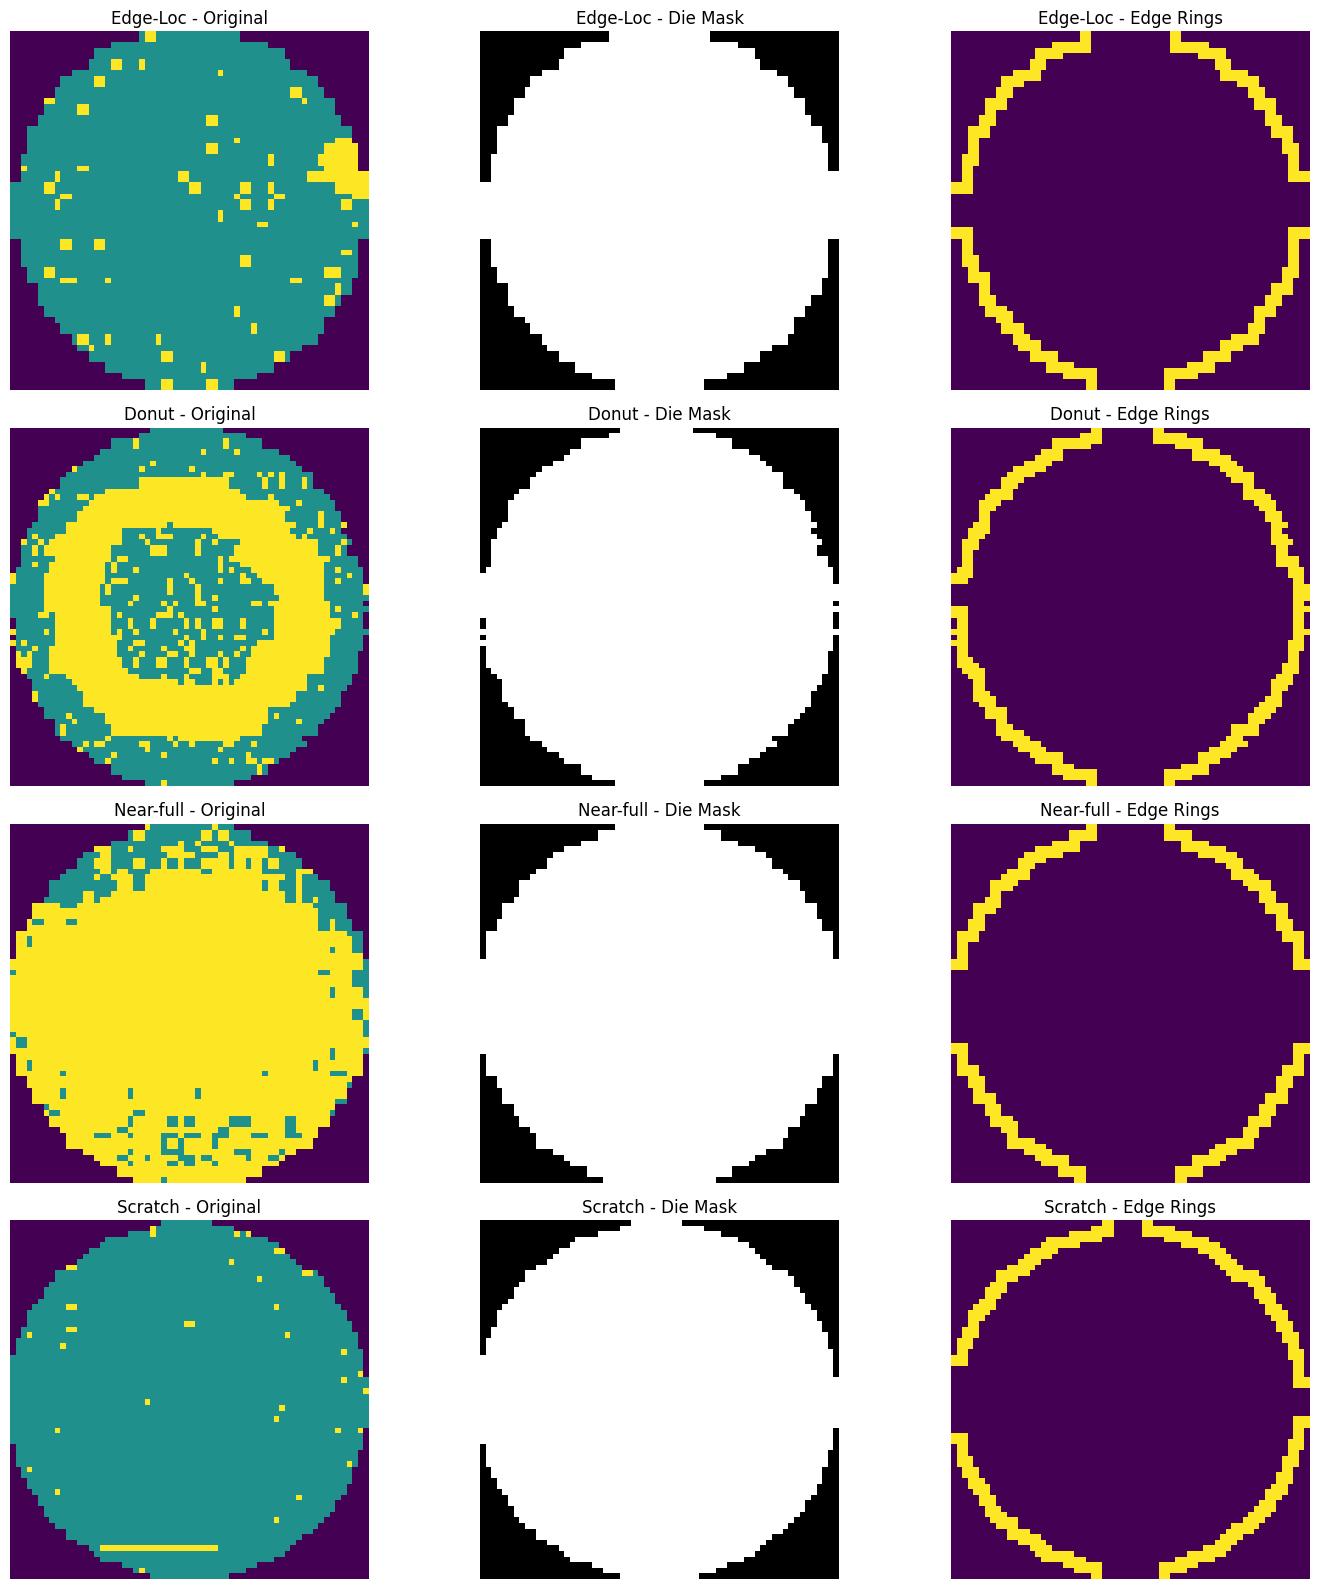

In [353]:
# Test ring visualization with different failure types
failure_types_to_test = ['Edge-Loc', 'Donut', 'Near-full', 'Scratch']

fig, axes = plt.subplots(len(failure_types_to_test), 3, figsize=(15, 4*len(failure_types_to_test)))

for i, failure_type in enumerate(failure_types_to_test):
    row = df_train.loc[df_train['failureType'] == failure_type].iloc[0]
    wafer_map = row['resizedWaferMap']
    ring_mask = ring_label_from_outside(wafer_map)
    
    # Original wafer map
    axes[i, 0].imshow(wafer_map, cmap='viridis', vmin=0, vmax=2)
    axes[i, 0].set_title(f'{failure_type} - Original')
    axes[i, 0].axis('off')
    
    # Die mask
    die_mask = ((wafer_map == PASS) | (wafer_map == FAIL)).astype(int)
    axes[i, 1].imshow(die_mask, cmap='gray')
    axes[i, 1].set_title(f'{failure_type} - Die Mask')
    axes[i, 1].axis('off')
    
    # Ring labels
    axes[i, 2].imshow(ring_mask, cmap='viridis')
    axes[i, 2].set_title(f'{failure_type} - Edge Rings')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [354]:
# TODO: From the dataframe select the 10 features we want to use and extract them as X and extract the numerical failure type labels as y. 
# Then, split dataset into training and validation set. Use RANDOM_SEED for random_state

# Select the 10 feature columns
feature_columns = ['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter',
                   'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
                   'yieldLoss', 'edgeYieldLoss']

X = df_train[feature_columns].values
y = df_train['numericFailureType'].values

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Feature dimensions: {X_train.shape[1]}")

Training set size: 2196
Validation set size: 550
Feature dimensions: 10


In [355]:
call_llm("""
why do we split into train and validation? what's the point of not using all the data for training?
""")

Splitting data into training and validation sets is a crucial practice in machine learning and model development for several reasons:

1. **Model Evaluation**: The primary purpose of a validation set is to evaluate the model's performance on unseen data. By setting aside a part of the data, you can check how well the model generalizes to new, unseen examples. This helps assess the model's true performance rather than just how well it fits the training data.

2. **Overfitting Prevention**: If you use all the data for training, the model may learn to memorize the training examples (overfitting), leading to poor generalization to new data. The validation set acts as a check on this tendency, helping you detect overfitting early in the training process.

3. **Hyperparameter Tuning**: Many machine learning algorithms have hyperparameters that need to be set before training. The validation set provides a way to tune these hyperparameters based on model performance. You can test various confi

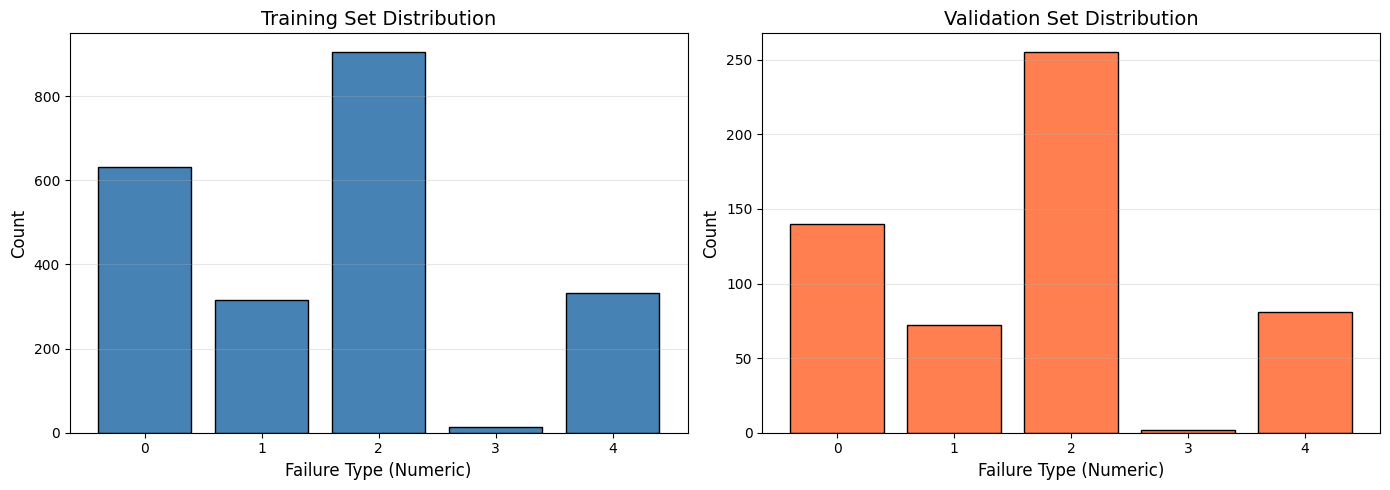


Training set distribution:
  Class 0: 631 samples (28.7%)
  Class 1: 316 samples (14.4%)
  Class 2: 904 samples (41.2%)
  Class 3: 13 samples (0.6%)
  Class 4: 332 samples (15.1%)

Validation set distribution:
  Class 0: 140 samples (25.5%)
  Class 1: 72 samples (13.1%)
  Class 2: 255 samples (46.4%)
  Class 3: 2 samples (0.4%)
  Class 4: 81 samples (14.7%)


In [356]:
# TODO: check train/validation distribution

# Count occurrences of each class in training and validation sets
train_counts = pd.Series(y_train).value_counts().sort_index()
valid_counts = pd.Series(y_valid).value_counts().sort_index()

# Create bar plot comparing distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
axes[0].bar(train_counts.index, train_counts.values, color='steelblue', edgecolor='black')
axes[0].set_title('Training Set Distribution', fontsize=14)
axes[0].set_xlabel('Failure Type (Numeric)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticks(train_counts.index)
axes[0].grid(axis='y', alpha=0.3)

# Validation set distribution
axes[1].bar(valid_counts.index, valid_counts.values, color='coral', edgecolor='black')
axes[1].set_title('Validation Set Distribution', fontsize=14)
axes[1].set_xlabel('Failure Type (Numeric)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticks(valid_counts.index)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print the distributions
print("\nTraining set distribution:")
for class_label, count in train_counts.items():
    percentage = (count / len(y_train)) * 100
    print(f"  Class {class_label}: {count} samples ({percentage:.1f}%)")

print("\nValidation set distribution:")
for class_label, count in valid_counts.items():
    percentage = (count / len(y_valid)) * 100
    print(f"  Class {class_label}: {count} samples ({percentage:.1f}%)")

### STEP 3. Model Training and Evaluation

You decide that a **Decision Tree** would be the easiest model to explain to others.  
However, relying on only one model wouldn’t be enough to judge its performance,  
so you also plan to build a **Support Vector Classifier (SVC)** for comparison.

Naturally, you’ll compare their **overall accuracy**,  
but you also decide to go a step further —  
by examining **accuracy per class** and the **confusion matrix** to see  
which **failure types** are most frequently misclassified.  
This insight will help you design a more accurate model later on.


In [357]:
# TODO: initialize Decision Tree classifier with max tree depth of 3 and use RANDOM_SEED and train the Decision Tree classifier with the training data

from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree with max depth of 3 for interpretability
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_SEED)

# Train the classifier on training data
dt_classifier.fit(X_train, y_train)

print("Decision Tree classifier trained successfully!")
print(f"Max depth: {dt_classifier.max_depth}")
print(f"Number of features: {dt_classifier.n_features_in_}")
print(f"Number of classes: {dt_classifier.n_classes_}")

Decision Tree classifier trained successfully!
Max depth: 3
Number of features: 10
Number of classes: 5


### Feature Scaling for SVC

SVC (Support Vector Classifier) is sensitive to feature scales. We'll use StandardScaler to normalize features before training both models.

In [358]:
# TODO: Scale features using StandardScaler for SVC
# Fit scaler on training data only, then transform all splits

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Original X_train shape: {X_train.shape}")
print(f"Scaled X_train_scaled shape: {X_train_scaled.shape}")
print(f"Features scaled to mean=0, std=1 for SVC optimization")

Feature scaling completed!
Original X_train shape: (2196, 10)
Scaled X_train_scaled shape: (2196, 10)
Features scaled to mean=0, std=1 for SVC optimization


In [359]:
call_llm("""
why does SVC need StandardScaler but Decision Tree doesn't? what does scaling actually do to the features?
""")

The need for feature scaling varies between different types of machine learning algorithms, and this is why Support Vector Classifier (SVC) typically requires scaling using `StandardScaler`, while Decision Trees do not.

### Why SVC Needs Scaling

1. **Distance-Based Algorithm**: SVC, especially when using the RBF kernel (a common choice), is sensitive to the distances between data points. It tries to find a hyperplane that maximizes the margin between different classes. If features are on different scales, the distance calculations between points can be dominated by features with larger ranges, which can distort the model.

2. **Kernel Functions**: The way kernels work in SVC involves calculating dot products in transformed (possibly infinite-dimensional) space. If the feature values are not scaled properly, some features may contribute more to the distance calculations, leading to suboptimal decision boundaries.

3. **Convergence**: Gradient-based optimization methods used in trainin

In [360]:
call_llm("""
Why max_depth=3 for the decision tree? is that enough to classify wafers accurately?
""")

Setting `max_depth=3` for a decision tree means that the tree will only create a maximum of three splits from the root to any leaf node. This restriction is a form of regularization aimed at preventing overfitting, where the model learns noise and intricate patterns in the training data rather than the underlying structure.

### Considerations for max_depth:

1. **Overfitting vs. Underfitting**:
   - **Overfitting**: A very deep tree may capture too much noise from the training data, leading to poor generalization on unseen data. It learns the training examples very well but fails to perform adequately on new examples.
   - **Underfitting**: A very shallow tree (like one with `max_depth=3`) may not be able to capture complex patterns in the data, leading to systematically poor predictions.

2. **Complexity of the Dataset**: 
   - The appropriate value for `max_depth` heavily depends on the complexity of the dataset and the relationships between the features and the target variable. If 

In [361]:
# TODO: Make a dictionary that is the reverse of the string2int mapping defined above.

# Create reverse mapping from numeric to string labels
int2string = {v: k for k, v in string2int.items()}

print("int2string dictionary:")
for num, label in sorted(int2string.items()):
    print(f"  {num}: {label}")

int2string dictionary:
  0: Center
  1: Donut
  2: Edge-Loc
  3: Near-full
  4: Scratch


In [362]:
call_llm("""
Why do i need int2string when i already have string2int? seems redundant?
""")

It might seem redundant at first glance, but both `int2string` and `string2int` serve different purposes in programming, and they are often used in different contexts.

Here's why both are useful:

1. **Different Functions**: 
   - `string2int` is a function that converts a string representation of an integer (like "42") into an actual integer type (like 42). This is useful when you're dealing with input data that comes as strings, such as user input or data read from files.
   - `int2string`, on the other hand, converts an integer type (like 42) back into its string representation (like "42"). This is necessary when you want to display numbers as strings, concatenate numbers with other strings, or store them in a format that requires strings.

2. **Data Flow**: In many applications, data flows between different types. For example, you might read data from a user or a file as strings, process these strings to integers, perform calculations, and then convert results back to strings for 

In [363]:
# TODO: Implement a function that calculates the prediction accuracy.
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    # Calculate the percentage of correct predictions
    correct = np.sum(pred_labels == true_labels)
    total = len(true_labels)
    accuracy = (correct / total) * 100
    
    return accuracy

In [364]:
call_llm("""
Is accuracy enough to evaluate my model or do i need other metrics?
""")

Accuracy is a valuable metric for evaluating the performance of a model, but it is not always sufficient by itself. Whether accuracy is enough depends on several factors, including the nature of your data, the specific problem you're trying to solve, and the balance of classes in your dataset. 

Here are some situations where you might need additional metrics:

1. **Imbalanced Classes**: If you have an imbalanced dataset where one class significantly outnumbers another, accuracy can be misleading. For example, if 90% of your samples belong to Class A and only 10% to Class B, a model that predicts all samples as Class A would have 90% accuracy, but it wouldn't be useful at all.

2. **Different Types of Errors**: In many applications, not all errors are equally harmful. For example, in medical diagnostics, missing a positive case (false negative) might be much more critical than incorrectly predicting a negative case (false positive). In such cases, metrics like precision, recall (sensit

In [365]:
# TODO: Implement a function that calculates the prediction accuracy for each failure type separately.
def calculate_per_class_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    # Get unique class labels
    unique_classes = np.unique(true_labels)
    
    # Dictionary to store accuracy for each class
    accuracies = {}
    
    for class_label in unique_classes:
        # Find indices where true label is this class
        class_indices = (true_labels == class_label)
        
        # Get predictions for this class
        class_pred = pred_labels[class_indices]
        class_true = true_labels[class_indices]
        
        # Calculate accuracy for this class
        if len(class_true) > 0:
            class_accuracy = (np.sum(class_pred == class_true) / len(class_true)) * 100
            # Convert numeric label to string using int2string
            class_name = int2string[class_label]
            accuracies[class_name] = class_accuracy
        
    return accuracies

In [366]:
call_llm("""
What's the difference between overall accuracy and per-class accuracy? why do i need both?
""")

Overall accuracy and per-class accuracy are two different ways to evaluate the performance of a classification model. Here’s a breakdown of each and why both are important:

### Overall Accuracy
- **Definition:** Overall accuracy measures the proportion of correctly predicted instances across the entire dataset. It is calculated as the number of correct predictions divided by the total number of instances.
  
  \[
  \text{Overall Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
  \]

- **Example:** If a model makes 90 correct predictions out of 100 total predictions, then the overall accuracy is 90%.

### Per-Class Accuracy
- **Definition:** Per-class accuracy (also known as class-specific accuracy) measures the proportion of correct predictions for each individual class separately. It is calculated for each class as the number of correct predictions for that class divided by the total number of instances of that class.
  
  \[
  \text{Per-Cla

In [367]:
# TODO: get the predicted labels of the training data and calculate the accuracy, and calculate the accuracy for each failure type
pred_train = dt_classifier.predict(X_train)
acc_train = calculate_accuracy(pred_train, y_train)
accuracies_train = calculate_per_class_accuracy(pred_train, y_train)

# Format for display
accuracies_train_str = {k: f"{v:.2f}%" for k, v in accuracies_train.items()}

print(f'Model accuracy on Decision Tree training data set is {acc_train:.2f}%')
print(f'Model accuracy on Decision Tree training data set for each class is {accuracies_train_str}')

Model accuracy on Decision Tree training data set is 89.21%
Model accuracy on Decision Tree training data set for each class is {'Center': '96.99%', 'Donut': '67.09%', 'Edge-Loc': '96.90%', 'Near-full': '100.00%', 'Scratch': '74.10%'}


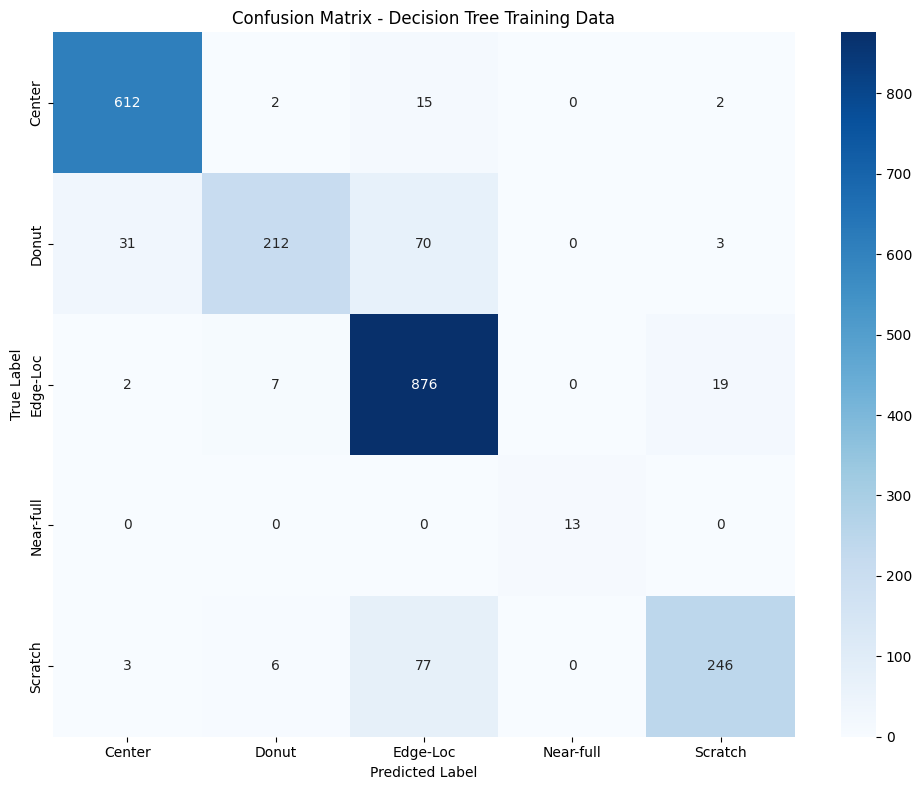

In [368]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm_train = confusion_matrix(y_train, pred_train)

# Get the class labels in the order they appear
class_labels = [int2string[i] for i in sorted(int2string.keys())]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Decision Tree Training Data')
plt.tight_layout()
plt.show()

In [369]:
call_llm("""
How do i read this confusion matrix? what do the numbers mean and what's the color scale for?
""")

A confusion matrix is a table used to evaluate the performance of a classification model. Here’s how to read and interpret it:

### Structure of the Confusion Matrix:

Typically, a confusion matrix for a binary classification problem is arranged like this:

```
                  Predicted Positive  |  Predicted Negative
------------------------------------------------------------
Actual Positive |        True Positive (TP)       |     False Negative (FN)
------------------------------------------------------------
Actual Negative |        False Positive (FP)      |      True Negative (TN)
```

### Meaning of Each Term:

- **True Positive (TP)**: The count of instances that were correctly predicted as positive.
- **False Negative (FN)**: The count of instances that were actual positive but were incorrectly predicted as negative.
- **False Positive (FP)**: The count of instances that were actual negative but were incorrectly predicted as positive.
- **True Negative (TN)**: The count of i

In [370]:
# TODO: get the predicted labels of the validation data and calculate the accuracy, and calculate the accuracy for each failure type
pred_valid = dt_classifier.predict(X_valid)
acc_valid = calculate_accuracy(pred_valid, y_valid)
accuracies_valid = calculate_per_class_accuracy(pred_valid, y_valid)

# Format for display
accuracies_valid_str = {k: f"{v:.2f}%" for k, v in accuracies_valid.items()}

print(f'Model accuracy on Decision Tree validation data set is {acc_valid:.2f}%')
print(f'Model accuracy on Decision Tree validation data set for each class is {accuracies_valid_str}')

Model accuracy on Decision Tree validation data set is 89.64%
Model accuracy on Decision Tree validation data set for each class is {'Center': '95.00%', 'Donut': '73.61%', 'Edge-Loc': '95.69%', 'Near-full': '100.00%', 'Scratch': '75.31%'}


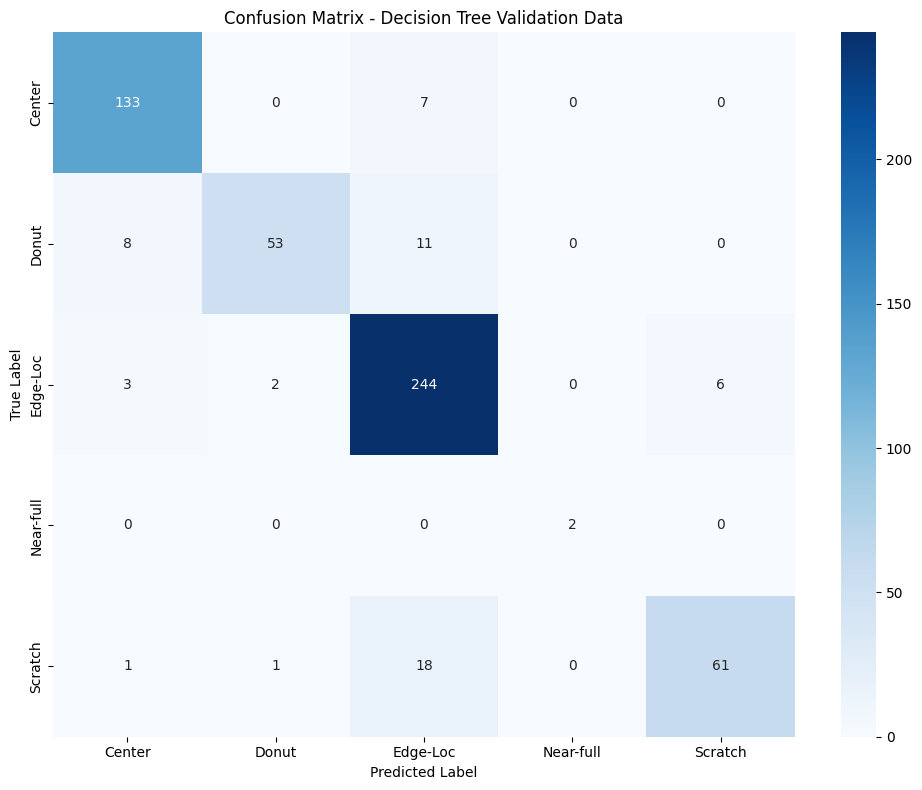

In [371]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.

# Compute confusion matrix for validation data
cm_valid = confusion_matrix(y_valid, pred_valid)

# Get the class labels in the order they appear
class_labels = [int2string[i] for i in sorted(int2string.keys())]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Decision Tree Validation Data')
plt.tight_layout()
plt.show()

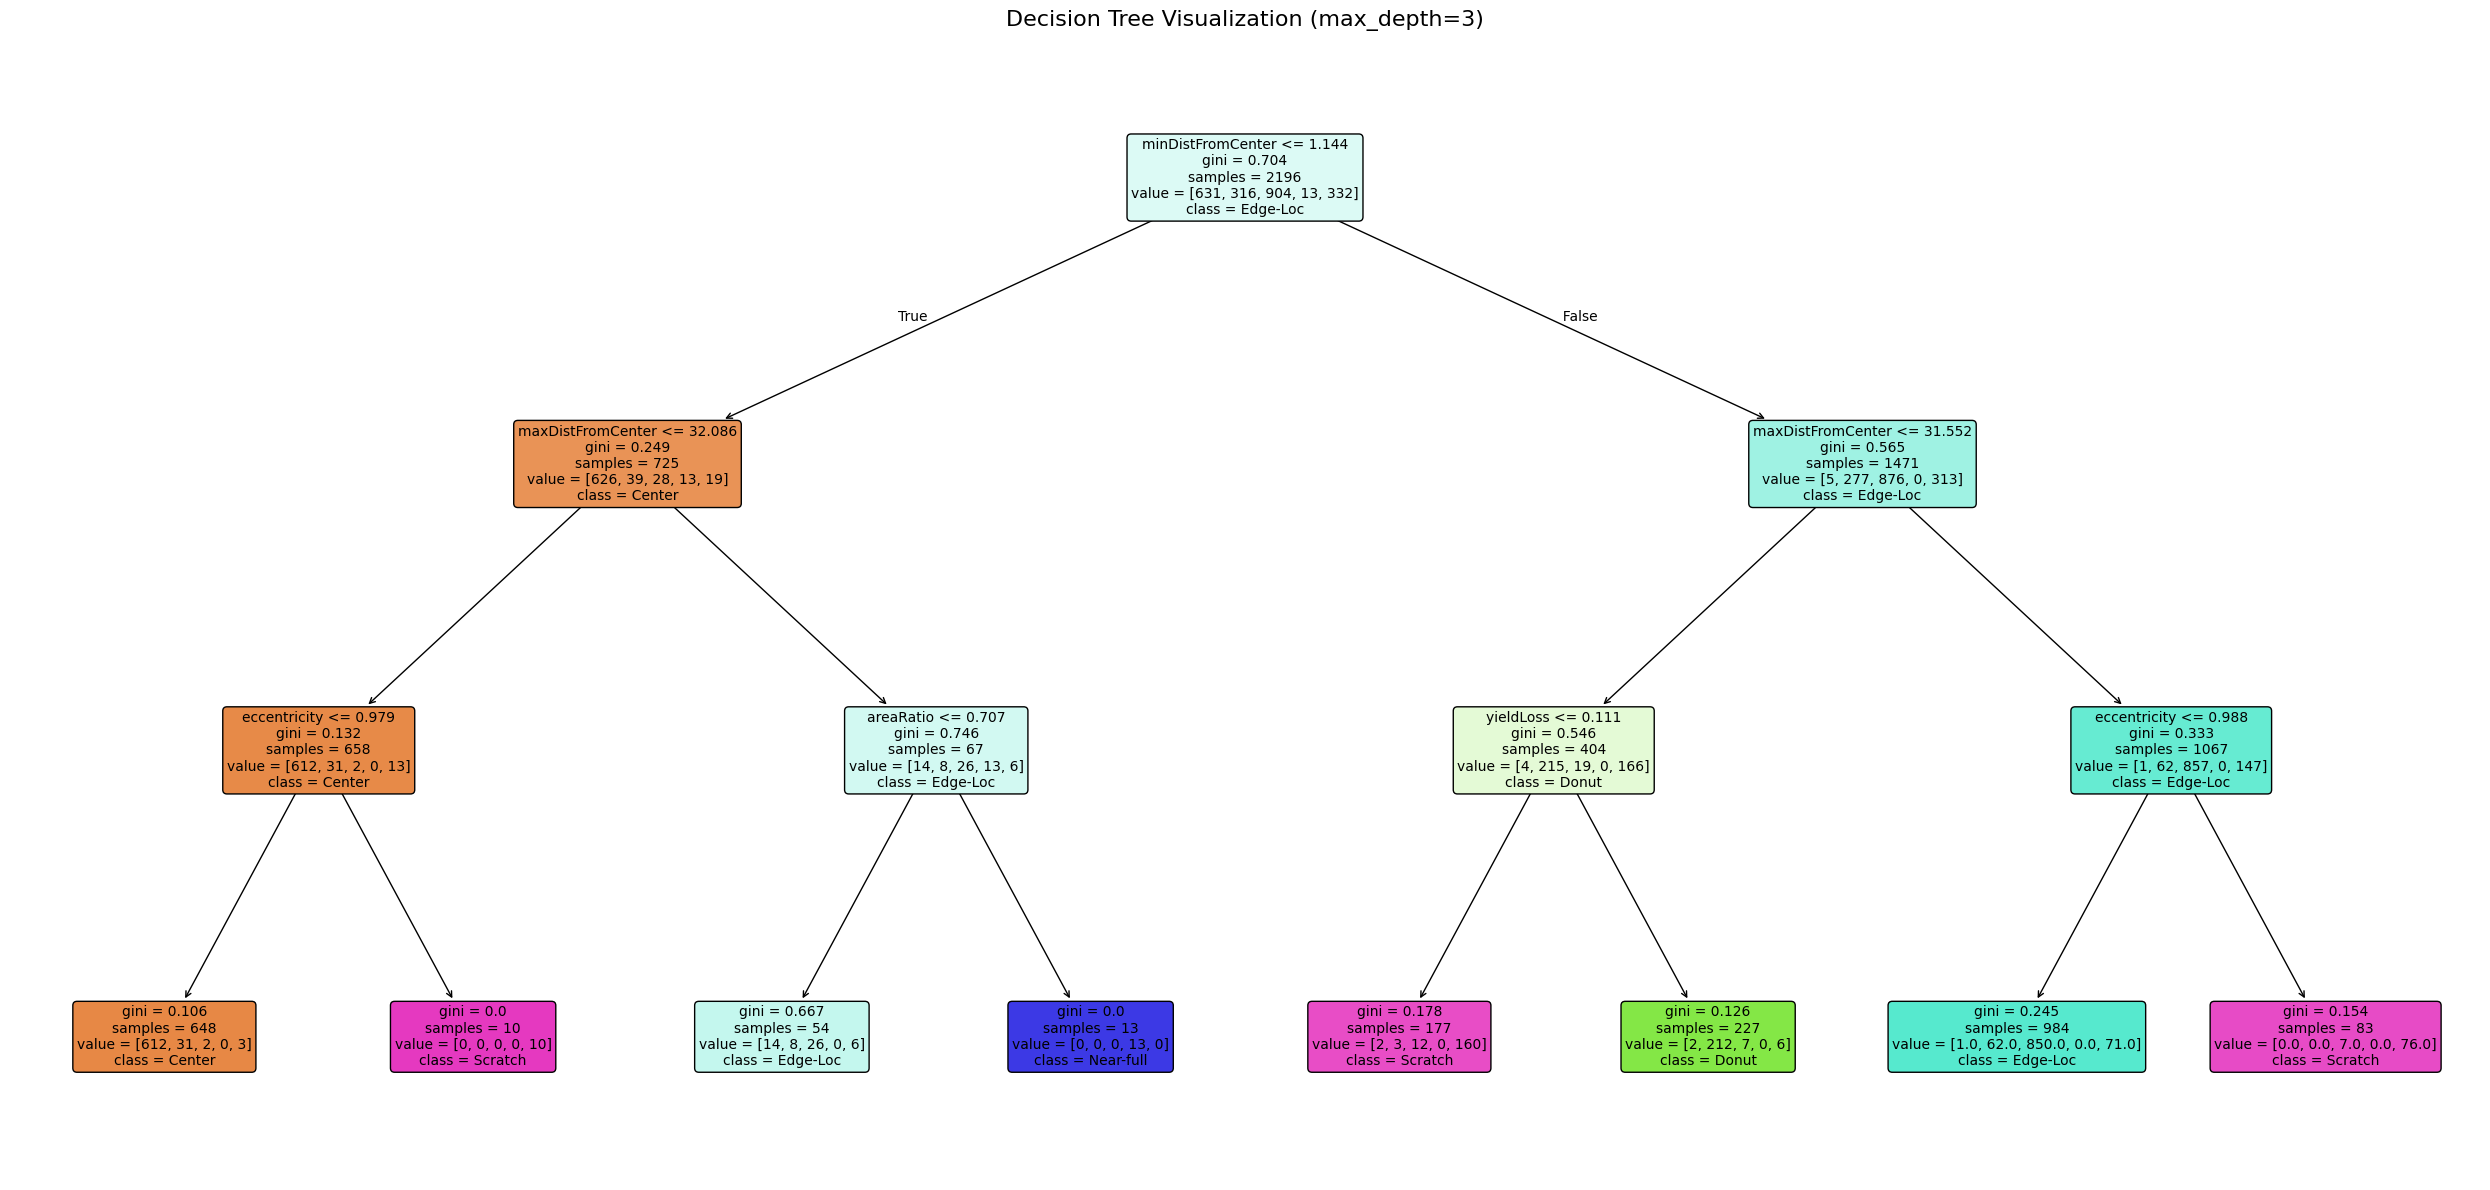

In [372]:
# TODO: Plot decision tree
# Below is an example call; you should show different wafer maps than example 
# (make the plot size different if the resulting plot looks exactly the same as the example)
from sklearn.tree import plot_tree

plt.figure(figsize=(25, 12))
plot_tree(dt_classifier, 
          feature_names=feature_columns,
          class_names=class_labels,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Visualization (max_depth=3)', fontsize=16)
plt.tight_layout()
plt.show()

In [373]:
call_llm("""
How do i read this decision tree diagram? 
""")

To help you read a decision tree diagram effectively, I can provide an overview of what a typical decision tree looks like and how to interpret its components. Here’s how to read it:

1. **Root Node**: This is where the tree starts. It represents the first decision point or question based on the most significant feature. It is often depicted at the top of the tree.

2. **Branches**: These are lines that connect nodes, representing the decision paths based on the answers to the questions at each node. Each branch leads to further nodes or leaves.

3. **Internal Nodes**: These are the nodes in between the root and the leaves. Each internal node represents a decision point (or question) that splits the data based on the feature or criteria relevant to the decision being made.

4. **Leaf Nodes**: These are the terminal nodes at the end of the branches. Leaf nodes represent outcomes or final decisions after making all necessary splits. They usually indicate the predicted class or value base

In [374]:
# TODO: Initialize SVC, use RANDOM_SEED and kernel and train the SVC with the training data
from sklearn.svm import SVC

svc_classifier = SVC(kernel='rbf', random_state=RANDOM_SEED)
svc_classifier.fit(X_train_scaled, y_train)
print("SVC classifier trained successfully!")
print(f"Kernel: {svc_classifier.kernel}")
print(f"Number of support vectors: {svc_classifier.n_support_}")

SVC classifier trained successfully!
Kernel: rbf
Number of support vectors: [116 152 148  12 129]


In [375]:
call_llm("""
what's the difference between decision tree and SVC? why am i training both?
""")

Decision Trees and Support Vector Classifiers (SVC) are both popular machine learning algorithms used for classification tasks, but they differ significantly in their approach, structure, and performance characteristics.

### Key Differences:

1. **Structure:**
   - **Decision Tree:**
     - A decision tree is a flowchart-like structure where each internal node represents a feature (attribute), each branch represents a decision rule, and each leaf node represents an outcome (class label).
     - The paths from the root to the leaf represent the classification decisions.
   - **SVC (Support Vector Classifier):**
     - SVC is based on the concept of finding a hyperplane in a high-dimensional space that best separates data points belonging to different classes.
     - It uses mathematical optimization techniques to maximize the margin (space) between the classes.

2. **Interpretability:**
   - **Decision Tree:**
     - Decision trees are easy to interpret and visualize, making them suita

In [376]:
# TODO: get the predicted labels of the training data and calculate the accuracy, and calculate the accuracy for each failure type
pred_train_svc = svc_classifier.predict(X_train_scaled)
acc_train_svc = calculate_accuracy(pred_train_svc, y_train)

accuracies_train_svc = calculate_per_class_accuracy(pred_train_svc, y_train)
accuracies_train_svc_str = {k: f"{v:.2f}%" for k, v in accuracies_train_svc.items()}

print(f"Model accuracy on SVC training data set is {acc_train_svc*100:.2f}%")
print("Per-class accuracies on training data:")
for failure_type, acc in accuracies_train_svc_str.items():
    print(f"  {failure_type}: {acc}")

Model accuracy on SVC training data set is 9690.35%
Per-class accuracies on training data:
  Center: 99.21%
  Donut: 91.14%
  Edge-Loc: 98.78%
  Near-full: 84.62%
  Scratch: 93.37%


In [377]:
call_llm("""
SVC improved from 89% to 97% after adding StandardScaler! why did feature scaling help so much?
""")

Feature scaling, such as using StandardScaler, can significantly improve the performance of some machine learning algorithms, particularly those based on distance metrics or gradient descent optimizations. Here’s why scaling helped your Support Vector Classifier (SVC) improve from 89% to 97%:

1. **Distance Calculation**:
   - SVCs, particularly with certain kernels (like the radial basis function (RBF) kernel), rely heavily on the distances between data points to define the decision boundary. If the features have very different scales, the distance calculations can be disproportionately influenced by high-magnitude features, potentially leading to suboptimal decision boundaries.

2. **Gradient Descent Optimization**:
   - While SVCs themselves do not necessarily use gradient descent directly, many optimization algorithms and other classifiers do. If features are on very different scales, the optimization process can be slow and might converge to poorer solutions. Scaling ensures that 

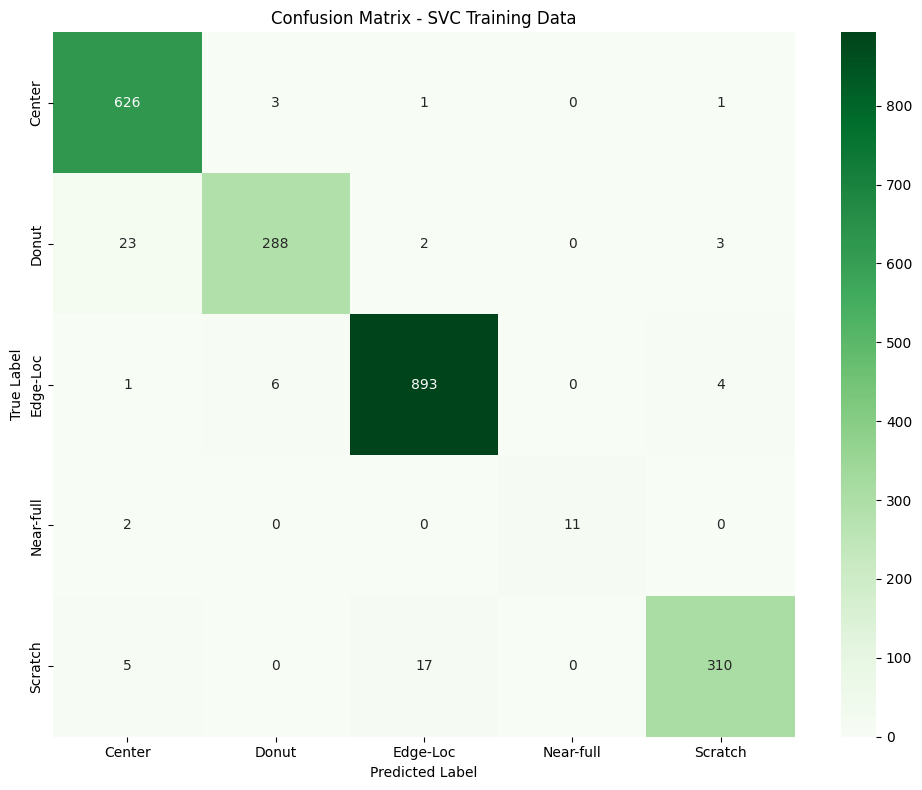

In [378]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.

# Compute confusion matrix for SVC training data
cm_train_svc = confusion_matrix(y_train, pred_train_svc)

# Get the class labels in the order they appear
class_labels = [int2string[i] for i in sorted(int2string.keys())]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train_svc, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVC Training Data')
plt.tight_layout()
plt.show()

In [379]:
call_llm("""
why does SVC's confusion matrix look different from DT's? which one is better?
""")

The different appearances of the confusion matrices for a Support Vector Classifier (SVC) and a Decision Tree (DT) can be attributed to several factors:

1. **Algorithm Characteristics**:
   - **SVC**: This algorithm uses support vectors to define the decision boundary, often resulting in a more complex decision surface. It can effectively handle non-linear relationships through the use of kernel functions.
   - **DT**: Decision Trees create a hierarchical model that splits data based on feature values which can lead to overfitting, particularly if not pruned.

2. **Evaluation Metrics**:
   - The accuracy, precision, recall, and F1-score can differ significantly between models. A detailed analysis of these metrics may explain discrepancies in their confusion matrices.

3. **Class Distribution**:
   - If your dataset is imbalanced (i.e., one class has significantly more samples than another), SVC might perform differently than DT. The number of true positives, false positives, true nega

In [380]:
# TODO: get the predicted labels of the validation data and calculate the accuracy, and calculate the accuracy for each failure type
pred_valid_svc = svc_classifier.predict(X_valid_scaled)
acc_valid_svc = calculate_accuracy(pred_valid_svc, y_valid)
accuracies_valid_svc = calculate_per_class_accuracy(pred_valid_svc, y_valid)

# Format for display
accuracies_valid_svc_str = {k: f"{v:.2f}%" for k, v in accuracies_valid_svc.items()}

print(f'Model accuracy on SVC validation data set is {acc_valid_svc:.2f}%')
print(f'Model accuracy on SVC validation data set for each class is {accuracies_valid_svc_str}')

Model accuracy on SVC validation data set is 97.64%
Model accuracy on SVC validation data set for each class is {'Center': '98.57%', 'Donut': '95.83%', 'Edge-Loc': '98.43%', 'Near-full': '100.00%', 'Scratch': '95.06%'}


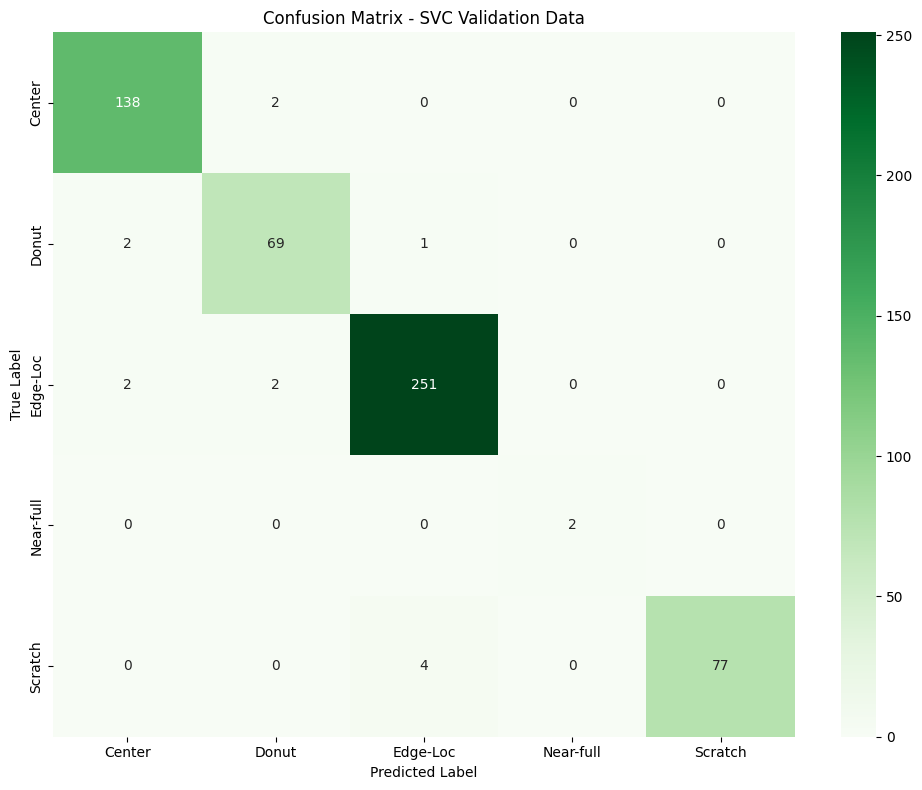

In [381]:
# TODO: compute the confusion matrix and plot it using seaborn heatmap
# Hint: Do not forget to convert numeric labels back to string labels. Provide x and y axes labels.

# Compute confusion matrix for SVC validation data
cm_valid_svc = confusion_matrix(y_valid, pred_valid_svc)

# Get the class labels in the order they appear
class_labels = [int2string[i] for i in sorted(int2string.keys())]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_valid_svc, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVC Validation Data')
plt.tight_layout()
plt.show()

In [382]:
call_llm("""
SVC now at 97.64% validation vs DT at 89.64%. SVC is clearly better with proper scaling. should i always use SVC going forward?
""")

Using Support Vector Classifier (SVC) might seem like the better choice in this case due to its higher validation accuracy compared to Decision Trees (DT). However, whether you should always use SVC going forward depends on several factors:

1. **Nature of the Data**: SVC can be more suitable for datasets with high dimensions, especially when there are clear margins of separation between classes. If your dataset exhibits these characteristics, SVC may consistently perform well.

2. **Data Scale and Distribution**: SVC is sensitive to the scaling of data. If your features vary significantly in scale, proper normalization or standardization is crucial. If your future datasets have similar characteristics (in scale and distribution), SVC may remain effective.

3. **Interpretability**: Decision Trees provide more interpretability compared to SVC. If explainability is important for your application, Decision Trees, despite their lower accuracy in this scenario, might be preferred.

4. **Ove

In [383]:
# TODO: Load test dataset as pandas dataframe
data_test = np.load('data/wafermap_test.npy', allow_pickle=True)
df_test = pd.DataFrame(data_test)
print(f"Test dataset loaded: {len(df_test)} samples")
print(f"Columns: {df_test.columns.tolist()}")

Test dataset loaded: 2026 samples
Columns: ['dieSize', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap']


In [384]:
# TODO: Apply data preparation function, feature extraction function, and create feature columns function on the test dataframe
# Reimport label in case it was overwritten
from skimage.measure import label as skimage_label
import builtins
if not callable(label):
    label = skimage_label

df_test = prepare_data(df_test, has_labels=False)
df_test['salientRegion'] = df_test.apply(get_salient_region, axis=1)
df_test = create_feature_columns(df_test)
print(f"Test data prepared and features extracted")
print(f"Number of test samples: {len(df_test)}")
print(f"Feature columns available: {[col for col in df_test.columns if col in feature_columns]}")

/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:38: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_once = binary_erosion(die_mask, square(3)).astype(int)
/var/folders/_z/yccpmt615jbdbqdrx7z1t4xc0000gn/T/ipykernel_16221/2741530096.py:44: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  eroded_twice = binary_erosion(eroded_once, square(3)).astype(int)


Test data prepared and features extracted
Number of test samples: 2026
Feature columns available: ['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter', 'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity', 'yieldLoss', 'edgeYieldLoss']


In [385]:
call_llm("""
Do i need to do the exact same preprocessing on test data as training? what happens if i mess this up?
""")

Yes, it is essential to apply the exact same preprocessing steps to your test data as you did to your training data. This ensures that the model can make accurate predictions based on the same input data format and conditions that it was trained on. Here are the key reasons for this requirement:

1. **Feature Consistency**: The model learns the relationship between its inputs (features) and outputs (labels) based on the training data. If the test data is preprocessed differently, the features may not match the model's expectations, leading to poor predictions.

2. **Scaling and Transformation**: If you perform normalization, standardization, or other transformations on the training data, you must compute the parameters (like mean, standard deviation, min, max, etc.) from the training data and then use those same parameters to preprocess the test data. If you compute these parameters from the test data instead, it can lead to data leakage and an inaccurate representation of the model's 

In [386]:
# TODO: From the dataframe select the 10 features we want to use and extract them as X
X_test = df_test[feature_columns].values
print(f"Test feature matrix shape: {X_test.shape}")
print(f"Features: {feature_columns}")

Test feature matrix shape: (2026, 10)
Features: ['areaRatio', 'perimeterRatio', 'maxDistFromCenter', 'minDistFromCenter', 'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity', 'yieldLoss', 'edgeYieldLoss']


In [387]:
# TODO: Get the predicted labels of the test data for both Decision Tree and SVC
# Hint: Don't forget to convert numeric labels back to string labels
pred_test_dt_numeric = dt_classifier.predict(X_test)
pred_test_svc_numeric = svc_classifier.predict(X_test_scaled)

# Convert numeric predictions to string labels
pred_test_tree = [int2string[pred] for pred in pred_test_dt_numeric]
pred_test_svc = [int2string[pred] for pred in pred_test_svc_numeric]

print(f"Decision Tree predictions: {len(pred_test_tree)} samples")
print(f"SVC predictions: {len(pred_test_svc)} samples")
print(f"Sample DT predictions: {pred_test_tree[:5]}")
print(f"Sample SVC predictions: {pred_test_svc[:5]}")

Decision Tree predictions: 2026 samples
SVC predictions: 2026 samples
Sample DT predictions: ['Center', 'Center', 'Center', 'Center', 'Scratch']
Sample SVC predictions: ['Center', 'Center', 'Center', 'Center', 'Center']


In [388]:
# Save output as `dt_scores.csv` and `svc_scores.csv`

pd.Series(pred_test_tree, name='failureType').to_csv('dt_scores.csv', header=True, index=False)
pd.Series(pred_test_svc, name='failureType').to_csv('svc_scores.csv', header=True, index=False)